# Car Price prediction. Project 7. "Возьмёте Бэтмобиль?"


## Прогнозирование стоимости автомобиля используя ML + DL (NLP + CV)



## Этапы решения
* "Наивная" модель, предсказывающая цену по модели и году выпуска для сравнения с последующими моделями
* EDA
* Обработка и генерация признаков
* Модель 1 на основе градиентного бустинга с помощью CatBoost
* Модель 2 на основе нейронных сетей и сравнение результатов
* Multi-input нейронная сеть для анализа табличных данных и текста одновременно
* Multi-input сеть + обработка изображений
* Ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
#!pip install lazypredict

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#from sklearn.feature_selection import SequentialFeatureSelector # нужна версия 0.24
#from lazypredict.Supervised import LazyRegressor #использовал единожды, закомментировал

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations as alb

# plt
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import seaborn as sns

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Seaborn      :', sns.__version__)
print('Tensorflow   :', tf.__version__)


Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Seaborn      : 0.11.1
Tensorflow   : 2.4.1


In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# SETTINGS

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set()

In [6]:
!pip freeze > requirements.txt

In [7]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
data_description_cleaned = pd.read_csv('../input/data-description-cleaned/data_descr.csv') # Загрузжаем уже подготовленный признак с текстовым описанием автомобилей
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# Functions

In [8]:
### Функция считает описательные статистики для числовых признаков датасета, возвращает датафрейм
def get_stats(dataset):
    col_types = dataset.dtypes.reset_index()
    col_types.columns=['Name', 'type']
    num_cols = list(col_types[col_types['type'] !='object']['Name'])
    stats = pd.DataFrame(columns=['feature_name', 'min', 'max', 'median', 'q1', 'q3', 'iqr', 'l_border', 'r_border'])
    
    for i in range(len(num_cols)):
        q1 = dataset[num_cols[i]].quantile(0.25)
        q2 = dataset[num_cols[i]].median()
        q3 = dataset[num_cols[i]].quantile(0.75)
        iqr = q3 - q1
        left_outliers_border = q1 - 1.5 * iqr
        right_outliers_border = q3 + 1.5 * iqr
        minimum = dataset[num_cols[i]].min()
        maximum = dataset[num_cols[i]].max()
        stats.loc[i] = [num_cols[i], minimum, maximum, q2, q1, q3, iqr, left_outliers_border, right_outliers_border]
    
    return stats

In [9]:
### Функция исправляющая столбец со сроком владения
### Убираем текст, переводим в дни
def ownership_fix(record):
    if record == None:
        return(None)
    digits = re.findall(r'\d+', record)
    letters = re.findall(r'\D+', record)
    if len(digits) == 2:
        return (int(digits[0])*356 + int(digits[1])*30)
    elif len(digits) == 1:
        if 'го' in letters[0] or 'ле' in letters[0]:
            return(int(digits[0])*356)
        if 'ме' in letters[0]:
            return(int(digits[0])*30)

In [10]:
### Функция для сокращения уникальных значений категориального признака

def cat_feature_fix(record, feature_count_df, top_feature_count):
    if feature_count_df.loc[record][0] < top_feature_count:
        return('other')
    else:
        return(record)

In [11]:
### Функция для определения типа продавца - автосалон или частник. Поиск ключевых слов в поле description

def seller_create(record):
    seller_keywords = [
        'наша компания', 'специальные предложения', 'выкуп', 'выгода до', 'лизинг для юр.и физ.лиц', 'рольф - официальный дилер',
        'срочный выкуп', 'дарим набор подарков', 'покупка у нас – правильный выбор!', 'атлант-м тушино - официальный дилер skoda',
        'дополнительная скидка', 'рассрочка', 'автоцентр', 'преимущества автокредитования:', 'кредит от', 'гк автомир',
        'скидка на выбранный автомобиль', 'код автомобиля', 'асц', 'все автомобили прошли', 'комиссионная продажа',
        'каско не обязательно', 'представлен major expert', 'ежедневно без выходных', 'выгода при обмене', 'при обмене на ваш автомобиль',
        'лот:', 'лот №', 'лот№','тест-драйв', 'подберем для вас', 'сертифицированные das weltauto', 'гк бизнес кар – сеть',
        'получить скидку', 'trade-in', 'трейд-ин', 'каждый автомобиль проходит', 'банков-партнеров', 'работаем ежедневно', '15 лет на рынке',
        'предпродажная подготовка', 'рольф ясенево с пробегом', 'официальным дилером', 'favorit', 'гк «автомир»', 'ждём вас ежедневно',
        'преимущества автокредитования', 'гарантированная выгода', 'с пробегом в наличии', 'дилерский центр', '2-й вязовский проезд',
        'автомобили с пробегом', 'в наличии более', 'автомобиль в наличии', 'гаражный номер', 'предпродажную подготовку', 'взнос',
        'автогермес уже более 20 лет', 'выгода', 'представлен в автосалоне', 'avilon', 'автопрага', 'наши сотрудники', 'торговых точек'
    ]

    for word in seller_keywords:
        if record.lower().find(word) != -1:
            return('COMMERCIAL')
    return('PRIVATE')

In [12]:
def preproc_data(df_input):
    '''Предварительная подготовка датасета для EDA'''
    df_output = df_input.copy()
     
    # ################### fix ##############################################################
    
    # Исправляем объем двигателя
    # У электрических двигателей ставим объем 2 литра, приблизительно эквивалентный мощности в 180 л.с.
    df_output.loc[df_output.engineDisplacement=='undefined LTR', 'engineDisplacement'] = '2 LTR'
    df_output.engineDisplacement=pd.to_numeric(df_output.engineDisplacement.str.strip(' LTR'))*1000
    #df_output.engineDisplacement.fillna(2000, inplace=True)
    
    # Исправляем мощность двигателя 
    df_output.enginePower = pd.to_numeric(df_output.enginePower.str.replace(u' N12', u''))
    
    # Исправляем столбец с количеством владельцев 
    df_output.Владельцы.fillna('3 или более',inplace=True)
    df_output.Владельцы = df_output.Владельцы.apply(lambda x: x.strip(re.findall('\D+', x)[0]))
    df_output.Владельцы = df_output.Владельцы.astype(int)
       
    # Переводим столбец Владение в месяцы
    df_output.Владение.fillna('', inplace=True)
    df_output.Владение = df_output.Владение.apply(ownership_fix)
    
    #################### Feature Engineering ####################################################
    
    # Создадим признак - возраст автомобиля в днях
    df_output.productionDate = pd.to_numeric(df_output.productionDate).astype('int32')
    df_output['age'] = df_output.productionDate.apply(lambda x: dt.date(x, 1, 1))
    df_output['age'] = (dt.date(2021, 4, 1) - df_output.age).astype('timedelta64[D]').astype('int32')
    
    # Заполним пропуски столбца "Владение" средим значением для автомобиля = возраст автомобиля/количество владельцев
    df_output.loc[df_output.Владение.isna(), 'Владение'] = df_output['age'] / df_output.Владельцы
    df_output.Владение = df_output.Владение.astype(int)
    
    return df_output

# Model 1: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.

In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [16]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

Пропуски есть только в столбце "Владение" и "Владельцы". Остальные данные без пропусков 

### Посчитаем описательные статистики

In [18]:
train_stats = get_stats(train)
train_stats

feature_name       min         max        median            q1            q3         iqr      l_border      r_border
0         mileage         1      999999  1.110000e+05  5.918125e+04  1.680000e+05   108818.75 -1.040469e+05  3.312281e+05
1       modelDate      1975        2019  2.011000e+03  2.007000e+03  2.014000e+03        7.00  1.996500e+03  2.024500e+03
2   numberOfDoors         2           5  4.000000e+00  4.000000e+00  5.000000e+00        1.00  2.500000e+00  6.500000e+00
3           price    301301    2.39e+07  1.300000e+06  8.000000e+05  2.299283e+06  1499283.25 -1.448925e+06  4.548208e+06
4  productionDate      1982        2020  2.013000e+03  2.009000e+03  2.016000e+03        7.00  1.998500e+03  2.026500e+03
5         sell_id  34212938  1100272894  1.099407e+09  1.097102e+09  1.099973e+09  2871271.50  1.092795e+09  1.104280e+09

## Пройдемся по признакам в test и сравним их с train, в случае присутствия аналогичного признака

### bodyType - Тип кузова

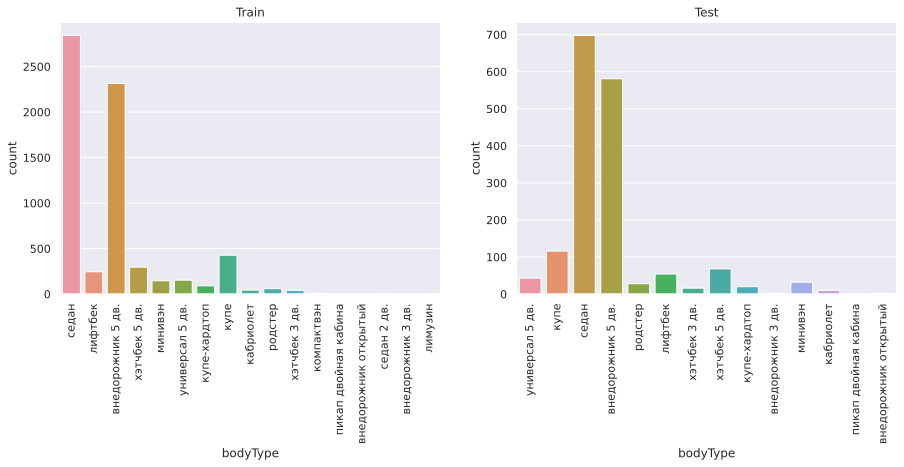

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='bodyType', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='bodyType', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак категориальный. В train преобладают седаны, на втором месте - внедорожники. Редко встречающиеся типы кузова можно объединить в одну категорию.

### brand - Марка автомобиля

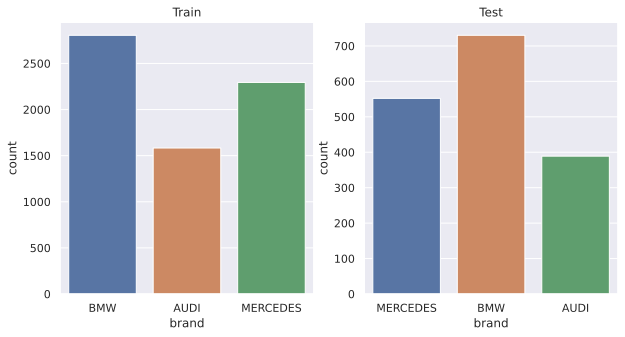

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='brand', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='brand', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак, перечень и распределение марок совпадает

Посмотрим на распределение целевой переменной по маркам авто

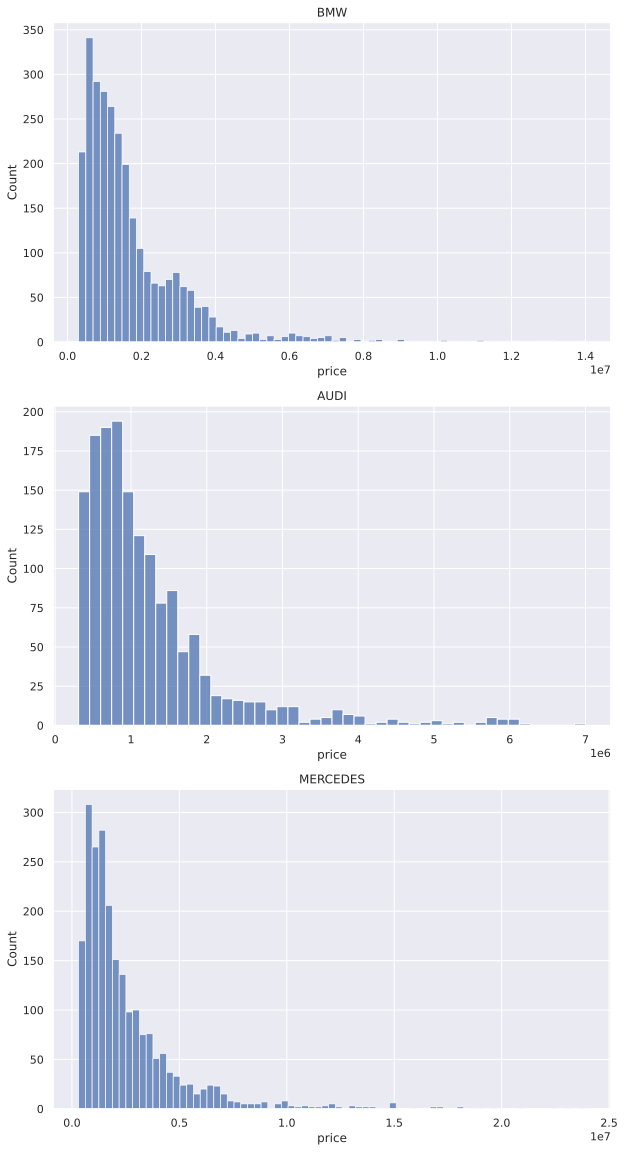

In [21]:
fig, ax = plt.subplots(3,1, figsize=(10,20))
for i in range(3):
    for j in range(1):
        sns.histplot(x=train.price[train.brand==train.brand.unique()[i]], ax=ax[i])
        ax[i].set_title(train.brand.unique()[i])
fig.show() 

Правые хвосты предположительно связаны с наличием в выдаче б/у автомобилей новых машин с высокой ценой, которые автосалоны выставляют на продажу как б/у. На выбросы надо посмотреть отдельно.

In [22]:
outliers = train[
    (train.price <= train_stats[train_stats.feature_name=='price'].iloc[0]['l_border']) |
    (train.price >= train_stats[train_stats.feature_name=='price'].iloc[0]['r_border'])
]
outliers.sample(10)

bodyType     brand       color                                        description engineDisplacement enginePower fuelType  mileage  modelDate       model_info                               name  numberOfDoors      price  productionDate     sell_id           vehicleConfiguration vehicleTransmission    Владельцы             Владение       ПТС  Привод   Руль
4011  внедорожник 5 дв.  MERCEDES      чёрный  Оригинал brabus, собирался в Германии ,700 л/с...            5.5 LTR     571 N12   бензин     5300       2015     G_KLASSE_AMG       63 AMG 5.5 AT (571 л.с.) 4WD              5  8750000.0            2016  1090587380  ALLROAD_5_DOORS AUTOMATIC 5.5      автоматическая  2 владельца                  NaN  Оригинал  полный  Левый
4115              седан  MERCEDES       белый  Автомобиль продается первым официальным дилеро...            5.5 LTR     585 N12   бензин    30132       2013     S_KLASSE_AMG  63 AMG Long 5.5 AT (585 л.с.) 4WD              4  4650000.0            2014  1100260548            SEDAN AUTOMATIC 5.5      автоматическая  3 или более                  NaN  Оригинал  полный  Левый
1599  внедорожник 5 дв.  MERCEDES      чёрный  [Smart]\nОригинал ПТС, По факту один владелец,...            5.5 LTR     585 N12   бензин    12822       2015   GLS_KLASSE_AMG       63 AMG 5.5 AT (585 л.с.) 4WD              5  7370000.0            2018  1096367940  ALLROAD_5_DOORS AUTOMATIC 5.5      автоматическая  3 или более                  NaN  Оригинал  полный  Левый
4977              седан       BMW       синий  АВТОПОРТ - ОФИЦИАЛЬНЫЙ ДИЛЕР BMW И MINI.\nМы б...            4.4 LTR     600 N12   бензин    20830       2017               M5              4.4 AT (600 л.с.) 4WD              4  6650000.0            2018  1099813706            SEDAN AUTOMATIC 4.4      автоматическая  2 владельца                  NaN  Оригинал  полный  Левый
980               седан  MERCEDES      чёрный  DC2 Пакет оборудования Премиум V/L 6\t\t\nПуль...            2.9 LTR     340 N12   дизель    49790       2017         S_KLASSE  400 d Long 2.9d AT (340 л.с.) 4WD              4  5250000.0            2017  1099776422            SEDAN AUTOMATIC 2.9      автоматическая   1 владелец                  NaN  Оригинал  полный  Левый
378   внедорожник 5 дв.      AUDI       синий  Автомобиль с полным НДС !\nВыставочный экземпл...            3.0 LTR     249 N12   дизель     4050       2015               Q7             3.0d AT (249 л.с.) 4WD              5  5769000.0            2019  1099576592  ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая   1 владелец                  NaN  Оригинал  полный  Левый
2771  внедорожник 5 дв.  MERCEDES  фиолетовый  •\tАвтомобиль состояние нового, зимой не экспл...            5.5 LTR     544 N12   бензин    53000       2012     G_KLASSE_AMG       63 AMG 5.5 AT (544 л.с.) 4WD              5  5300000.0            2015  1076529916  ALLROAD_5_DOORS AUTOMATIC 5.5      автоматическая  2 владельца   4 года и 5 месяцев  Оригинал  полный  Левый
1161  внедорожник 5 дв.  MERCEDES      чёрный  Автомобиль покупался у оф.дилера в начале 2015...            5.5 LTR     544 N12   бензин    53190       2012     G_KLASSE_AMG       63 AMG 5.5 AT (544 л.с.) 4WD              5  4890000.0            2015  1100146646  ALLROAD_5_DOORS AUTOMATIC 5.5      автоматическая  3 или более                  NaN  Дубликат  полный  Левый
5278              седан  MERCEDES      чёрный  Продам Mеrсеdеs-Bеnz Mауbасh S-Класс I (Х222) ...            3.0 LTR     367 N12   бензин    64298       2017  S_CLASS_MAYBACH          450 3.0 AT (367 л.с.) 4WD              4  6650000.0            2017  1099557708            SEDAN AUTOMATIC 3.0      автоматическая   1 владелец  2 года и 10 месяцев  Оригинал  полный  Левый
5113              седан       BMW       серый  Автомобиль из демонстрационного парка по спец ...            4.4 LTR     625 N12   бензин     2700       2017               M5  Competition 4.4 AT (625 л.с.) 4WD              4  8411850.0            2019  1092815512            SEDAN AUTOM

Все ок, это либо свежие года выпуска автомобилей, либо эксклюзивные премиальные комплектации 

### color - цвет автомобиля

In [23]:
print(sorted(train.color.unique()))
print(sorted(test.color.unique()))

['бежевый', 'белый', 'голубой', 'жёлтый', 'зелёный', 'золотистый', 'коричневый', 'красный', 'оранжевый', 'пурпурный', 'розовый', 'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный']
['бежевый', 'белый', 'голубой', 'жёлтый', 'зелёный', 'золотистый', 'коричневый', 'красный', 'оранжевый', 'пурпурный', 'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный']


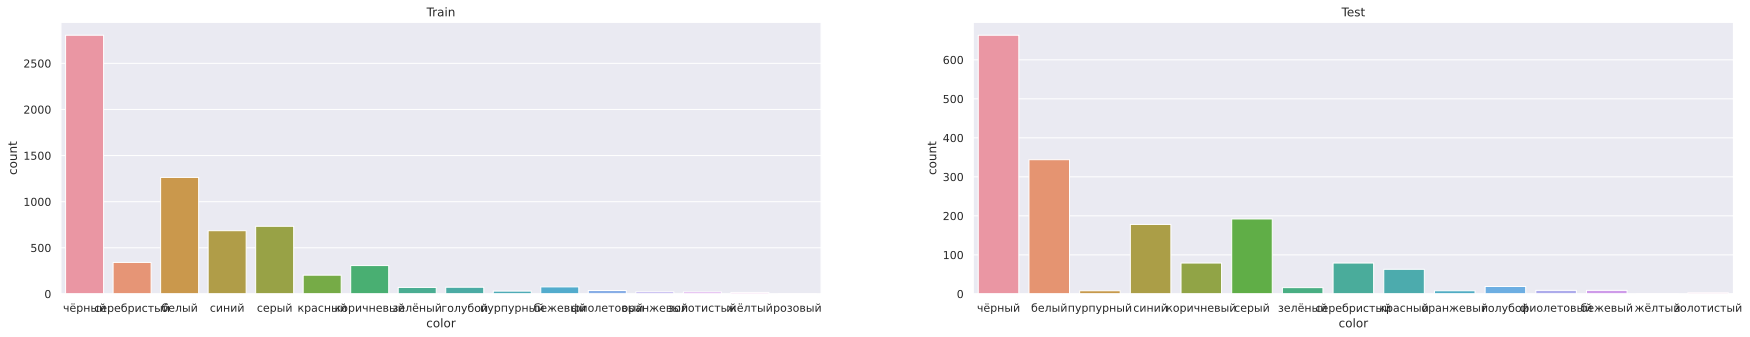

In [24]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='color', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='color', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Список цветов идентичен в train и test, кроме розового, который отсутствует в test. Редкие цвета надо объединить в отдельную категорию.

### description - Текстовые комментарии к объявлению

In [25]:
train.description[0]

'Авто на бодром ходу.  Все работает отлично.  По электрике,ходовой.,АКПП ДВС нареканий нет..,   Масло не ест. .!!!Салон ухожен. На запчасти денег не жалел. Жидкости все поменял. Крашена одна дверь левая задняя. Штрафов и ограничений нет. ..!  Торг при осмотре. Возможен обмен на внедорожник или коммерческий транспорт. '

Поле, которое мы будем использовать при построении NN с NLP

### engineDisplacement - Объем двигателя

In [26]:
sorted(train.engineDisplacement.unique())[20:]

['3.1 LTR',
 '3.2 LTR',
 '3.4 LTR',
 '3.5 LTR',
 '3.6 LTR',
 '3.7 LTR',
 '3.8 LTR',
 '4.0 LTR',
 '4.1 LTR',
 '4.2 LTR',
 '4.3 LTR',
 '4.4 LTR',
 '4.6 LTR',
 '4.7 LTR',
 '4.8 LTR',
 '4.9 LTR',
 '5.0 LTR',
 '5.2 LTR',
 '5.4 LTR',
 '5.5 LTR',
 '5.6 LTR',
 '5.8 LTR',
 '5.9 LTR',
 '6.0 LTR',
 '6.2 LTR',
 '6.3 LTR',
 '6.6 LTR',
 'undefined LTR']

In [27]:
train[train.engineDisplacement=='undefined LTR']

bodyType brand    color                                        description engineDisplacement enginePower fuelType  mileage  modelDate model_info                    name  numberOfDoors      price  productionDate     sell_id         vehicleConfiguration vehicleTransmission   Владельцы             Владение       ПТС  Привод   Руль
2296  хэтчбек 5 дв.   BMW   чёрный  Автомобиль в наличии Москве , с ПТС , производ...      undefined LTR     184 N12  электро     9000       2017         I3  S Electro AT (136 кВт)              5  2719000.0            2019  1100083262  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец                  NaN  Оригинал  задний  Левый
3725  хэтчбек 5 дв.   BMW   чёрный  BMW i3 Электромобиль с бензиновым генератором,...      undefined LTR     170 N12  электро    39500       2017         I3    Electro AT (126 кВт)              5  2299711.0            2017  1098041130  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец  2 года и 11 месяцев  Оригинал  задний  Левый
3726  хэтчбек 5 дв.   BMW  голубой  Прибыло из Америки в августе 20 года. Полная и...      undefined LTR     170 N12  электро    28800       2017         I3    Electro AT (126 кВт)              5  2170000.0            2017  1100097316  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец                  NaN  Оригинал  задний  Левый
5862  хэтчбек 5 дв.   BMW    белый  В наличии! Автомобиль куплен в США! Комплектац...      undefined LTR     170 N12  электро    35810       2013         I3    Electro AT (126 кВт)              5  1690000.0            2016  1100153696  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец                  NaN  Оригинал  задний  Левый
6283  хэтчбек 5 дв.   BMW   чёрный  Авто в идеальном состоянии\nЕсть REX (range ex...      undefined LTR     170 N12  электро    60000       2013         I3    Electro AT (126 кВт)              5  1790000.0            2015  1097395090  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец                  NaN  Оригинал  задний  Левый

In [28]:
test[test.engineDisplacement=='undefined LTR']

bodyType brand        color description engineDisplacement enginePower fuelType  mileage  modelDate model_info                  name  numberOfDoors  productionDate     sell_id         vehicleConfiguration vehicleTransmission   Владельцы Владение       ПТС  Привод   Руль
1005  хэтчбек 5 дв.   BMW  серебристый           .      undefined LTR     170 N12  электро    89942       2013         I3  Electro AT (126 кВт)              5            2014  1100166318  HATCHBACK_5_DOORS AUTOMATIC      автоматическая  1 владелец      NaN  Оригинал  задний  Левый

Признак по происхождению числовой. Похож на категориальный, но будем обрабатывать его как числовой, переведя его в мл.
'undefined LTR' - электромобили, укажем для них объем двигателя = 0 

In [29]:
tmp=preproc_data(train)

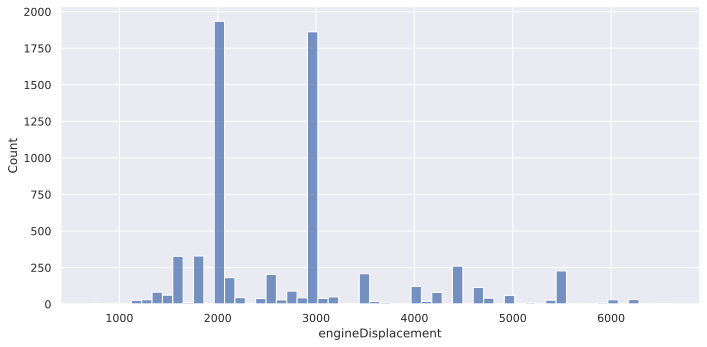

In [30]:
sns.displot(x=tmp.engineDisplacement, kde=False, rug=False, height=5, aspect=2)

Видны популярные размеры двигателей 2.0, 3.0

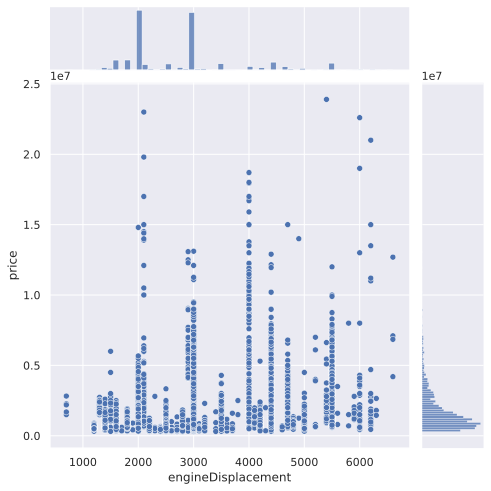

In [31]:
sns.jointplot(x='engineDisplacement', y='price', data=tmp, kind='scatter', height=7)

Среди двигателей большего объема больше дорогих авто.

### enginePower - Мощность двигателя

In [32]:
#столбец замусорен, используем временный датасет с очищенными признаками
tmp=preproc_data(train)

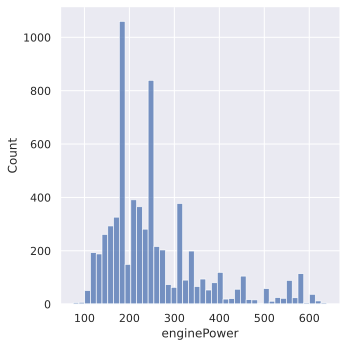

In [33]:
sns.displot(x=tmp.enginePower, kde=False, rug=False)

Признак числовой. Распределение смещено. Виден "налоговый" пик в 249 л.с., после которого резко повышается ставка налога на автомобиль. Автопроизводители искусствено ограничивают мощность двигателей на этом уровне. Посмотрим на взаимосвязь цены и мощности.

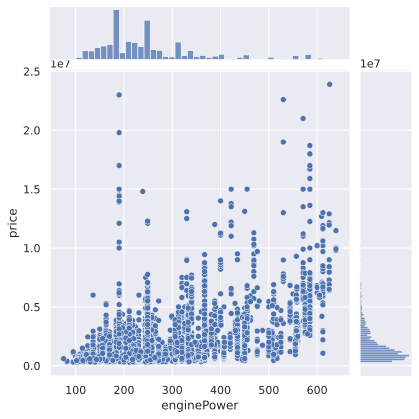

In [34]:
sns.jointplot(x='enginePower', y='price', data=tmp, kind='scatter')

Ожидал увидеть более линейную зависимость.

### fuelType - Тип топлива

In [35]:
print(sorted(train.fuelType.unique()))
print(sorted(test.fuelType.unique()))

['бензин', 'гибрид', 'дизель', 'электро']
['бензин', 'гибрид', 'дизель', 'электро']


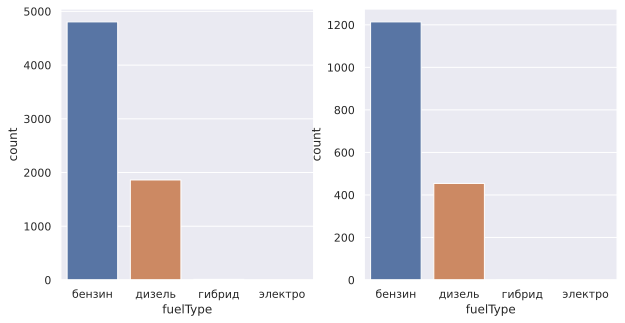

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='fuelType', data=train, ax=ax[0])
sns.countplot(x='fuelType', data=test, ax=ax[1])
fig.show()

Признак категориальный. Соотношение автомобилей по типу топлива одинаковое. Гибридов и электромобилей очень мало.

### mileage - пробег

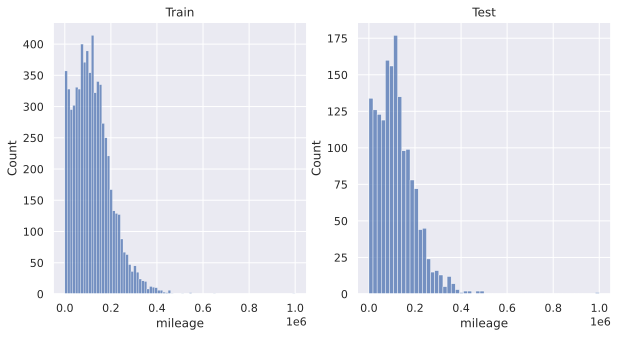

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(x='mileage', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.histplot(x='mileage', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Числовой признак. Распределение смещено. Преобладают авто с пробегом от 80 до 150 тыс. км.

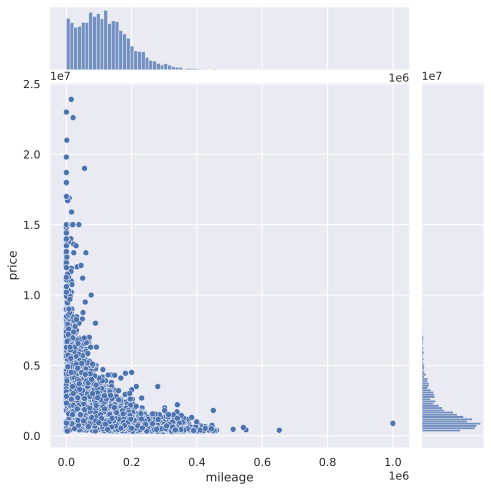

In [38]:
sns.jointplot(x='mileage', y='price', data=train, kind='scatter', height=7)

Ну для этого признака взаимосвязь пробега и цены более наглядна, чем для мощности. Зависимость похожа на 1/x.

### modelDate - Дата выхода модели в продажу

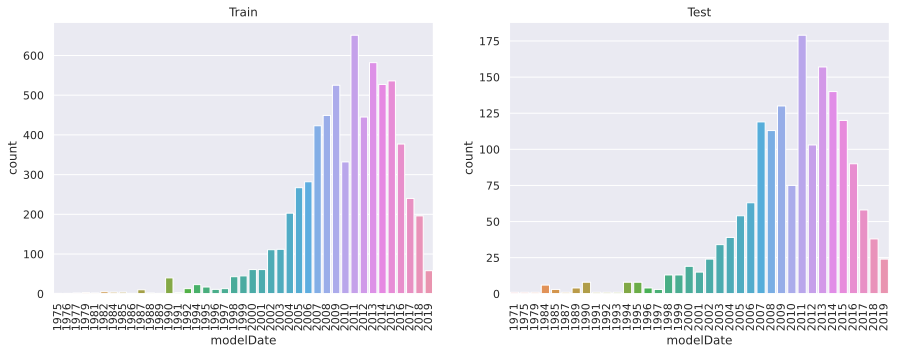

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='modelDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='modelDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак числовой. Распределения одинаковы в train и test Посмотрим на связь с ценой

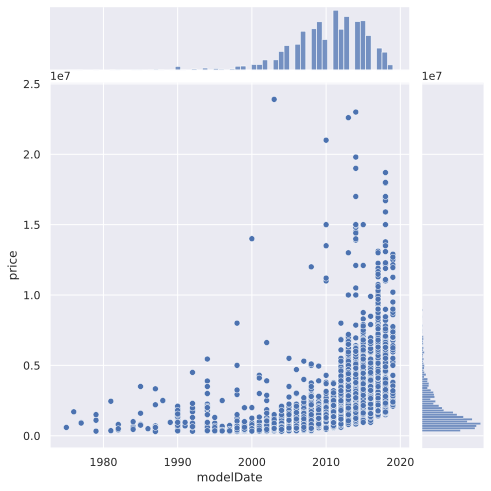

In [40]:
sns.jointplot(x='modelDate', y='price', data=train, kind='scatter', height=7)

Тут все более-менее закономерно, чем позднее модель, тем она и дороже. В отличие от проекта №6 отсутствуют коллекционные дорогие авто древних годов выпуска.

### model_info - Наименование модели

In [41]:
test.model_info.unique()

array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
       'GL_KLASSE', 'A6', '1ER', 'X5', 'X3', 'S_KLASSE',
       'S_CLASS_MAYBACH', 'G_KLASSE', 'E_KLASSE', 'X7', 'Q5', 'A3',
       'B_KLASSE', '4', 'CLS_KLASSE_AMG', 'RS3', 'X6', 'C_KLASSE', 'X1',
       'S8', 'Q3', 'X6_M', '7ER', 'GLS_KLASSE', 'A7', 'GLC_KLASSE', 'TT',
       'Q8', 'M3', 'M4', 'C_KLASSE_AMG', 'X4', 'G_KLASSE_AMG', 'VITO',
       'M_KLASSE', 'CLA_KLASSE', 'TTS', 'GLK_KLASSE', 'SLK_KLASSE_AMG',
       'CLS_KLASSE', 'R_KLASSE', 'S_KLASSE_AMG', 'VIANO', 'GLE_KLASSE',
       'S5', 'AMG_GT', 'A8', 'M_KLASSE_AMG', 'A_KLASSE', 'M5', 'X5_M',
       'GLE_KLASSE_COUPE_AMG', 'ALLROAD', 'GLE_KLASSE_COUPE',
       'E_KLASSE_AMG', 'GLA_CLASS', 'SLS_AMG', 'AMG_GLC_COUPE',
       'V_KLASSE', 'GLE_KLASSE_AMG', 'X2', 'A4_ALLROAD', 'CL_KLASSE',
       'SLK_KLASSE', 'CLA_KLASSE_AMG', 'RS5', 'X_KLASSE', 'W123', 'A1',
       'S6', 'M6', 'M1', '2ER', '8ER', 'RS6', 'SL_KLASSE_AMG', 'S7', 'M2',
       'CL_KLASSE_AMG', 'Z4', 'X

In [42]:
train.model_info.unique()

array(['5ER', 'A6', 'E_KLASSE', 'A5', 'C_KLASSE', '7ER', '3ER', 'X4',
       'M_KLASSE', 'S_KLASSE_AMG', 'Q5', 'CLA_KLASSE', 'GLA_CLASS', 'X1',
       'Q7', 'X2', 'X5', 'B_KLASSE', 'X6_M', 'S_KLASSE', 'VITO', 'A3',
       '1ER', 'CLS_KLASSE', 'X6', 'S_CLASS_MAYBACH', 'CL_KLASSE',
       'G_KLASSE_AMG', 'GLC_KLASSE', 'GLS_KLASSE', 'A8', 'A4',
       'GLE_KLASSE_COUPE_AMG', 'X3', 'Q3', 'X7', 'G_KLASSE',
       'GLS_KLASSE_AMG', 'I3', 'VIANO', 'GL_KLASSE', 'V_KLASSE',
       'SLK_KLASSE', 'GLC_COUPE', 'CLS_KLASSE_AMG', 'A_KLASSE', 'S7', '4',
       'A7', '6ER', 'RS6', 'M_KLASSE_AMG', 'GLK_KLASSE', 'R_KLASSE',
       'GLE_KLASSE', 'Z4', 'A1', 'C_KLASSE_AMG', 'GLE_KLASSE_AMG',
       'GLC_KLASSE_AMG', 'Z3', 'CLK_KLASSE', 'X5_M', 'M6', 'ALLROAD',
       'SLS_AMG', 'S5', '2GRANDTOURER', 'SL_KLASSE', 'E_KLASSE_AMG',
       'W124', 'GLE_KLASSE_COUPE', 'SLC_KLASSE', 'TT', 'S8',
       'CLA_KLASSE_AMG', 'R8', 'M5', '2ER', 'RSQ3', 'S4', 'CL_KLASSE_AMG',
       'Q8', 'AMG_GT', 'GLA_CLASS_AMG', 'M4'

In [43]:
print(len(test.model_info.unique()))
print(len(train.model_info.unique()))

101
118


Категориальный признак с названием модели, пока оставим в таком виде.

### name - Наименование авто

In [44]:
print(len(test.name.unique()))
print(len(train.name.unique()))

536
900


In [45]:
train.name.sample(20)

5634                          200 2.0 AT (184 л.с.)
4951                         200 1.6 AMT (156 л.с.)
4359              750i xDrive 4.4 AT (450 л.с.) 4WD
1615                 63 AMG S 5.5 AT (585 л.с.) 4WD
3554                         325i 2.5 AT (218 л.с.)
3893                      560 4.0 AT (469 л.с.) 4WD
2656                      35i 3.0 AT (306 л.с.) 4WD
6604                     30d 3.0d AT (245 л.с.) 4WD
3666                             1.8 CVT (160 л.с.)
4906                     Long 3.0 AT (290 л.с.) 4WD
6377    250 d экстра длинный 2.1d AT (190 л.с.) 4WD
3320                      20i 2.0 AT (184 л.с.) 4WD
101                          2.5d AT (180 л.с.) 4WD
6185                             1.8 AMT (190 л.с.)
251                          200 1.6 AMT (156 л.с.)
4697                      300 2.0 AT (245 л.с.) 4WD
6665           250 d длинный 2.1d AT (190 л.с.) 4WD
1805             530d xDrive 3.0d AT (249 л.с.) 4WD
4825             M850i xDrive 4.4 AT (530 л.с.) 4WD
763         

Признак содержит комбинацию модель + трансмиссия + мощность + тип привода. То есть является комбинацией существующих признаков. Но попробуем вытащить из него признаки, указывающие на особенности автомобиля

### numberOfDoors - количество дверей

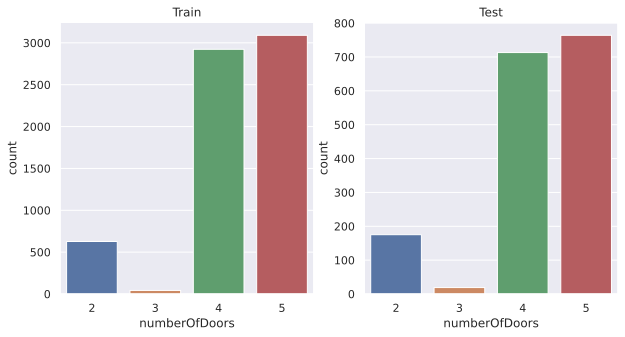

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='numberOfDoors', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='numberOfDoors', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признаков в train и test совпадает

### productionDate - Дата производства автомобиля

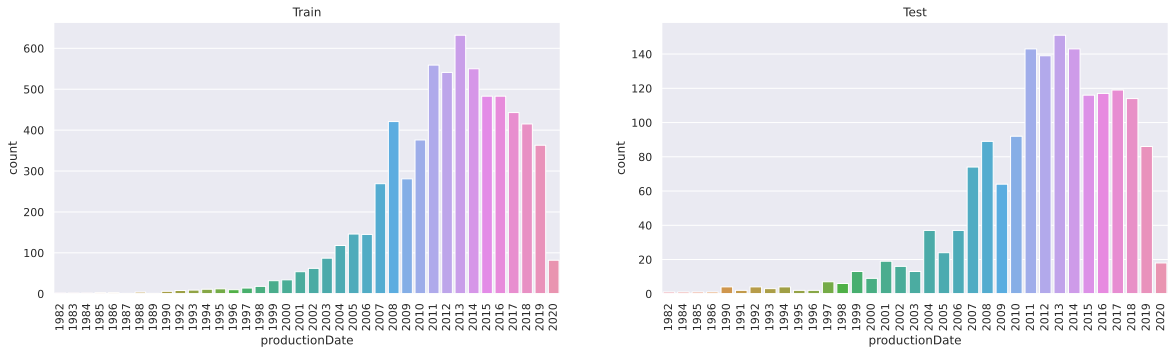

In [47]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.countplot(x='productionDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='productionDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()


Признак числовой. Распределения в test и train похожи. Заметен провал кризисного 2009 года.

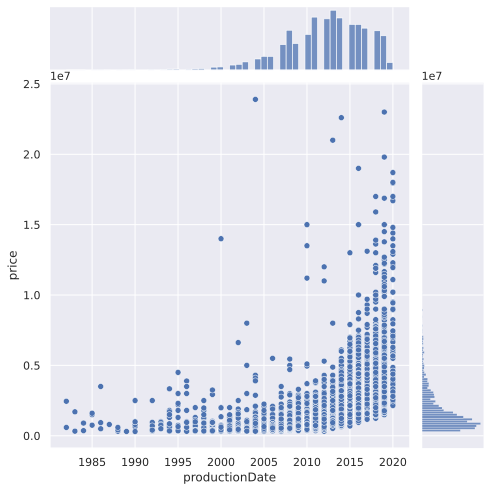

In [48]:
sns.jointplot(x='productionDate', y='price', data=train, kind='scatter', height=7)

Взаимосвязь цены и года выпуска авто логичная.

### vehicleConfiguration

In [49]:
test.vehicleConfiguration.sample(20)

1406      ALLROAD_5_DOORS AUTOMATIC 3.0
1535      ALLROAD_5_DOORS AUTOMATIC 3.0
1006                    SEDAN ROBOT 1.4
543                     SEDAN ROBOT 1.6
147       ALLROAD_5_DOORS AUTOMATIC 2.1
499       ALLROAD_5_DOORS AUTOMATIC 3.0
739       ALLROAD_5_DOORS AUTOMATIC 2.0
1096                 COUPE VARIATOR 1.8
612                 SEDAN AUTOMATIC 1.6
2                   COUPE AUTOMATIC 2.5
3                   SEDAN AUTOMATIC 2.0
1431    HATCHBACK_3_DOORS AUTOMATIC 2.0
738       ALLROAD_5_DOORS AUTOMATIC 3.0
1362     ALLROAD_3_DOORS MECHANICAL 3.0
450       ALLROAD_5_DOORS AUTOMATIC 4.8
786                     SEDAN ROBOT 3.0
788                     COUPE ROBOT 2.0
1361                SEDAN AUTOMATIC 1.6
124                 SEDAN AUTOMATIC 2.8
720                 SEDAN AUTOMATIC 3.5
Name: vehicleConfiguration, dtype: object

Признак дублирует имеющуюся информацию. Убираем.

### vehicleTransmission - привод автомобиля

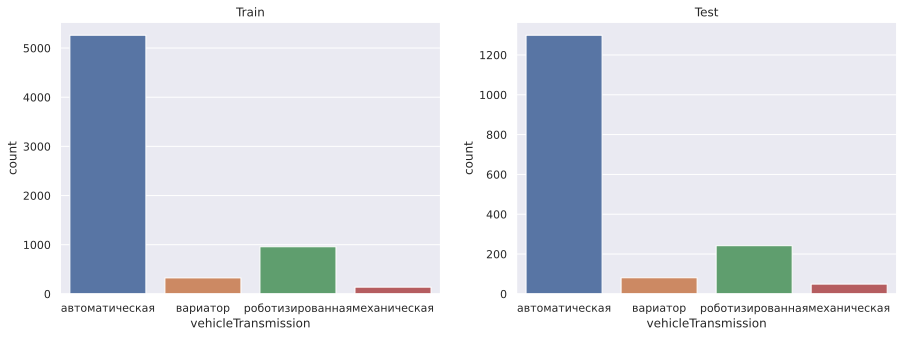

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='vehicleTransmission', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vehicleTransmission', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признака в train и test совпадает

### Владельцы

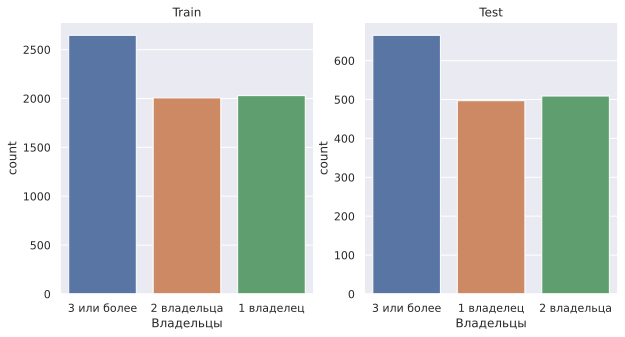

In [51]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='Владельцы', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Владельцы', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Картина в train и test одинаковая

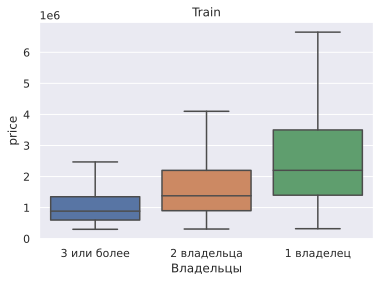

In [52]:
sns.boxplot(x='Владельцы', y='price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Влияние на цену количества владельцев - явно выражено

### Владение

In [53]:
train.Владение.head(10)

0                   NaN
1     8 лет и 6 месяцев
2                   NaN
3    4 года и 9 месяцев
4    2 года и 9 месяцев
5     6 лет и 9 месяцев
6                   NaN
7     4 года и 3 месяца
8                   NaN
9                   NaN
Name: Владение, dtype: object

Признак содержит много пропусков. В проекте №6 я его выбросил. В этот раз попробую заполнить пропуски средним значением владения для конкретного авто. Признак получаем делением возраста авто на количество владельцев.

In [54]:
tmp=preproc_data(train)

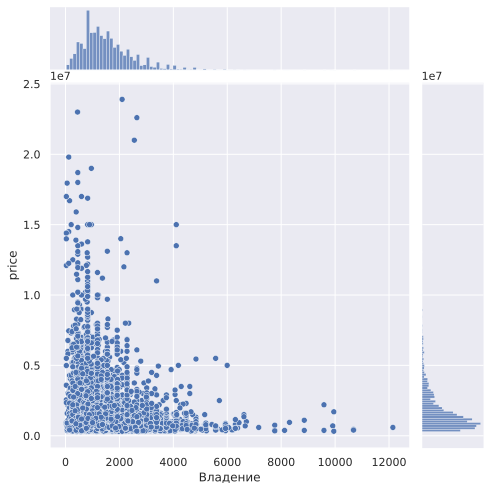

In [55]:
sns.jointplot(x='Владение', y='price', data=tmp, kind='scatter', height=7)

Получается, чем меньше срок владения автомобилем последним владельцем, тем выше цена

### ПТС

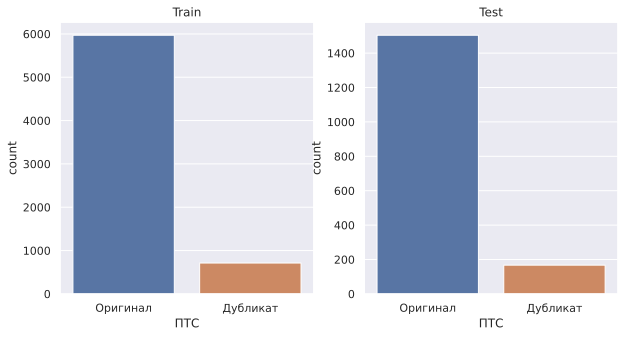

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='ПТС', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='ПТС', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Бинарный признак. В обоих датасетах преобладает большинство авто с оригиналом ПТС

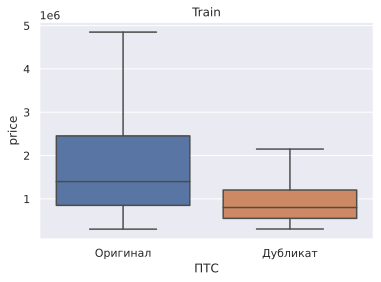

In [57]:
sns.boxplot(x='ПТС', y='price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Машины с дубликатами ПТС сильно дешевле. Но скорее всего и старше по возрасту.

### Привод

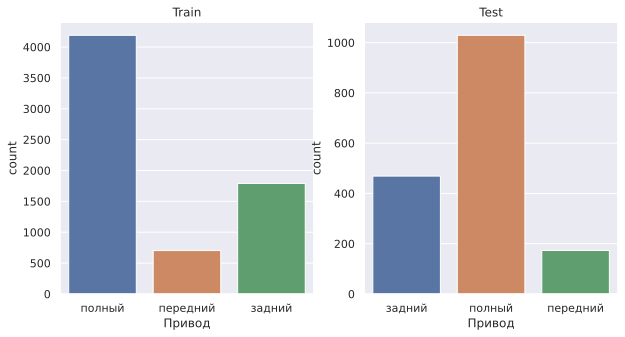

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='Привод', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Привод', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак категориальный. Преобладают переднеприводные авто. Удивительно, что заднеприводных больше, чем переднеприводных. Судя по всему это обусловлено подборкой марок автомобилей - Бмв, Мерседес, Ауди.

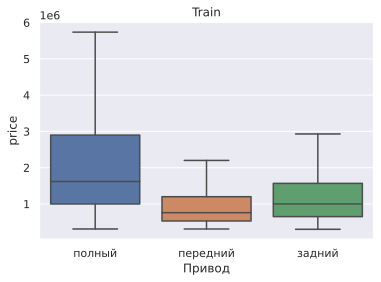

In [59]:
sns.boxplot(x='Привод', y='price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Полноприводные машины дороже. Переднеприводные - дешевле заднеприводных.

### Руль

In [60]:
train.Руль.value_counts()

Левый     6680
Правый       2
Name: Руль, dtype: int64

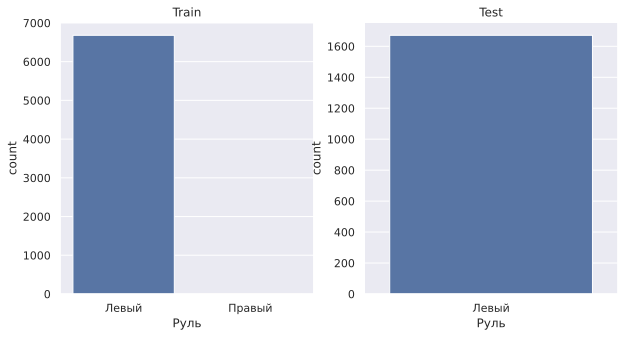

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='Руль', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Руль', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак бинарный. В train есть 2 праворульных авто, в test таковые отсутствуют.

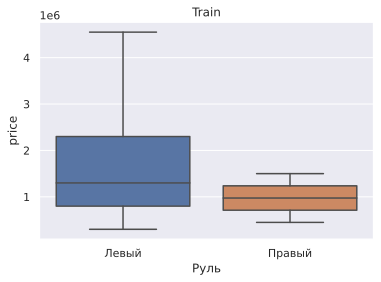

In [62]:
sns.boxplot(x='Руль', y='price', data=train, showfliers=False)
plt.title('Train')
plt.show()

На стоимость влияет, оставляем.

Итоги обзора признаков:

* bodyType - категориальный, необходимо сократить
* brand - категориальный
* color - категориальный, необходимо сократить
* description - текстовый, используем в NLP
* engineDisplacement - числовой, представленный как текст, очищаем, переводим в числовой вид и приводим объем к мл.
* enginePower - числовой, представленный как текст, очищаем, переводим в числовой вид
* fuelType - категориальный,
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, ивзлекаем дополнительный признаки об ососбенностях авто, убираем
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - ссылкка на изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - является комбинацией других столбцов, убираем
* vehicleTransmission - категориальный
* Владельцы - категориальный, убираем один пропуск, очищаем от текстовой информации, приводим к числовому виду
* Владение - числовой, представленный как текст, переводим в числовой вид, заполняем пропуски
* ПТС - категориальный, бинарный
* Привод - категориальный
* Руль - категориальный, бинарный

# PreProc Tabular Data

In [63]:
# Разделим features по типу

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'Владение', 'age'] #'pwr_per_litre', 'mileage_per_age'
    
bin_cols = ['seller_type', 'ПТС', 'Руль']
       
cat_cols = ['bodyType', 'Владельцы', 'brand', 'Привод', 'vehicleTransmission', 'color', 'fuelType', 'model_info', 'numberOfDoors']

drop_cols = ['description', 'name', 'sell_id', 'vehicleConfiguration' ]

len(num_cols)+len(bin_cols)+len(cat_cols)

19

In [64]:
# Объединим датасеты, предварительно пометив train и test
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения Price, заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [65]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name', 'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'sample', 'price'], dtype='object')

In [66]:
def preproc_data_main(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    df_output = preproc_data(df_output)

    # ################### Предобработка ################################################################### 
    
    # Сокращаем количество типов кузова
    df_output.bodyType = df_output.bodyType.apply(lambda x: x.split()[0])
    
    # Сокращаем количество цветов авто
    top_colors_count = int(np.percentile(data.color.value_counts().values, 99))
    colors_count_df = pd.DataFrame(data.color.value_counts())
    df_output.color = data.color.apply(lambda x: cat_feature_fix(x, colors_count_df, top_colors_count))
    
    # ################### Feature Engineering ####################################################
   
    # Создадим новый категориальный признак - тип продавца, на основе ключевых слов в признаке 'description'
    df_output.description = df_output.description.astype('str')
    df_output['seller_type'] = df_output.description.apply(seller_create)
    
    #Создадим новый числовой признак - литровая мощность двигателя - ухудшает метрику
    #df_output['pwr_per_litre'] = df_output['enginePower'] / df_output['engineDisplacement']
    
    #пробег машины в день - ухудшает метрику
    #df_output['mileage_per_age'] = df_output['mileage'] / df_output['age']
    
    # ################### Numerical Features ############################################################## 
          
    # Нормализация данных
    for col in num_cols:
        df_output[col] = df_output[col].apply(lambda w: np.log(w + 1))
    
    
    scaler = RobustScaler()
    df_output[num_cols] = scaler.fit_transform(df_output[num_cols])
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    # бинарные признаки
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df_output[column] = label_encoder.fit_transform(df_output[column])
        
    # Извлечем дополнительную информацию из столбца 'name'
    extra_features = ['Pullman','AMG','Long','BlueTEC','BlueEFFICIENCY','Competition','S-tronic','экстра', 'длинный']
    for feature in extra_features:
        df_output['name_' + feature] = df_output['name'].apply(lambda x: int(feature in x))
        
    # One-Hot Encoding: 
    df_output = pd.get_dummies(df_output, columns=cat_cols)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # убираем не нужные для модели признаки
    df_output.drop(drop_cols, axis = 1, inplace=True)
    
        
    return df_output

In [67]:
# Запускаем и проверяем, что получилось
data_preproc = preproc_data_main(data)
data_preproc.columns

Index(['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'Владение', 'ПТС', 'Руль', 'sample', 'price',
       ...
       'model_info_X_KLASSE', 'model_info_Z1', 'model_info_Z3', 'model_info_Z3M', 'model_info_Z4', 'model_info_Z8', 'numberOfDoors_2', 'numberOfDoors_3', 'numberOfDoors_4', 'numberOfDoors_5'], dtype='object', length=179)

In [68]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 179 entries, engineDisplacement to numberOfDoors_5
dtypes: float64(8), int64(13), uint8(158)
memory usage: 2.6 MB


In [69]:
data_preproc.sample(5)

engineDisplacement  enginePower   mileage  modelDate  productionDate  Владение  ПТС  Руль  sample     price       age  seller_type  name_Pullman  name_AMG  name_Long  name_BlueTEC  name_BlueEFFICIENCY  name_Competition  name_S-tronic  name_экстра  name_длинный  bodyType_внедорожник  bodyType_кабриолет  bodyType_компактвэн  bodyType_купе  bodyType_купе-хардтоп  bodyType_лимузин  bodyType_лифтбек  bodyType_минивэн  bodyType_пикап  bodyType_родстер  bodyType_седан  bodyType_универсал  bodyType_хэтчбек  Владельцы_1  Владельцы_2  Владельцы_3  brand_AUDI  brand_BMW  brand_MERCEDES  Привод_задний  Привод_передний  Привод_полный  vehicleTransmission_автоматическая  vehicleTransmission_вариатор  vehicleTransmission_механическая  vehicleTransmission_роботизированная  color_other  color_чёрный  fuelType_бензин  fuelType_гибрид  fuelType_дизель  fuelType_электро  model_info_100  model_info_1ER  model_info_2ACTIVETOURER  model_info_2ER  model_info_2GRANDTOURER  model_info_3ER  model_info_4  \
1009           -0.829831    -0.383943 -1.261128   0.855654        0.713223 -0.170134    1     0       0       0.0 -1.099772            0             0         0          0             0                    0                 0              0            0             0                     0                   0                    0              0                      0                 0                 1                 0               0                 0               0                   0                 0            1            0            0           0          1               0              0                0              1                                   1                             0                                 0                                     0            1             0                0                0                1                 0               0               0                         0               0                        0               0             1   
1661           -0.829831     0.115686 -0.003361  -0.285785       -0.142857  0.793100    1     0       0       0.0  0.135352            1             0         0          0             0                    0                 0              0            0             0                     0                   0                    0              0                      0                 0                 0                 0               0                 0               1                   0                 0            1            0            0           0          1               0              1                0              0                                   1                             0                                 0                                     0            1             0                1                0                0                 0               0               0                         0               0                        0               0             0   
3277           -0.594783    -0.602327  0.954642  -1.431776       -1.288274 -1.798211    0     0       1  510000.0  0.871042            1             0         0          0             0                    0                 0              0            0             0                     0                   0                    0              0                      0                 0                 0                 0               0                 0               1                   0                 0            0            0            1           0          1               0              1                0              0                                   0                             0                                 1                                     0            0             1                1                0                0                 0               0               0                         0               0                        0               1             0   
50

In [70]:
data_preproc.isna().sum()

engineDisplacement                      0
enginePower                             0
mileage                                 0
modelDate                               0
productionDate                          0
Владение                                0
ПТС                                     0
Руль                                    0
sample                                  0
price                                   0
age                                     0
seller_type                             0
name_Pullman                            0
name_AMG                                0
name_Long                               0
name_BlueTEC                            0
name_BlueEFFICIENCY                     0
name_Competition                        0
name_S-tronic                           0
name_экстра                             0
name_длинный                            0
bodyType_внедорожник                    0
bodyType_кабриолет                      0
bodyType_компактвэн               

### Посмотрим на корреляцию числовых признаков

<AxesSubplot:>

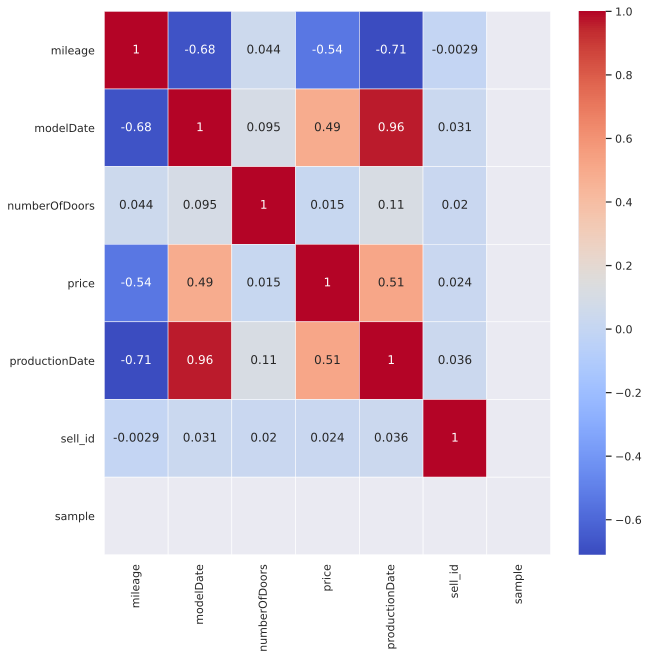

In [71]:
correlation = train.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

<AxesSubplot:>

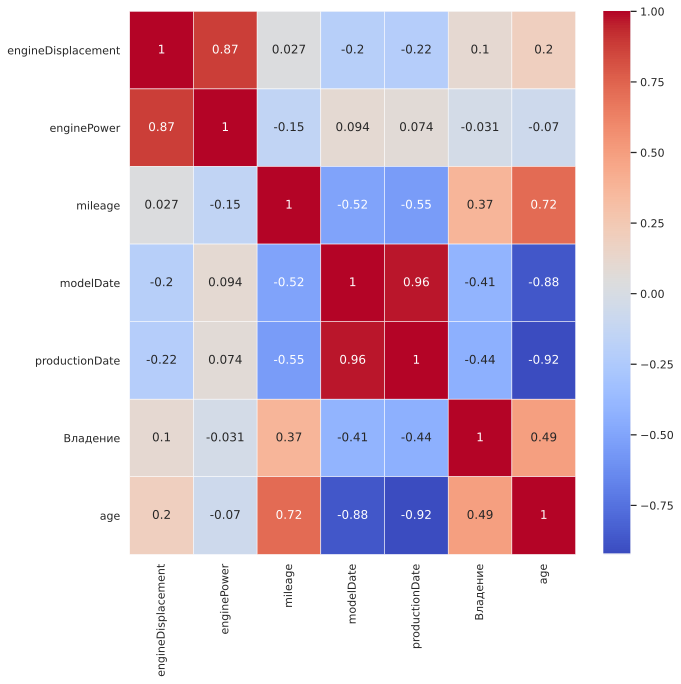

In [72]:
correlation = data_preproc[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

В обучающей выборке цена зависит от пробега и возраста автомобиля.
После обработки видна обратная корреляция между пробегом и годом выпуска и прямая корреляция объема и мощности двигателя. 

### Оценим значимость признаков

ANOVA

<AxesSubplot:>

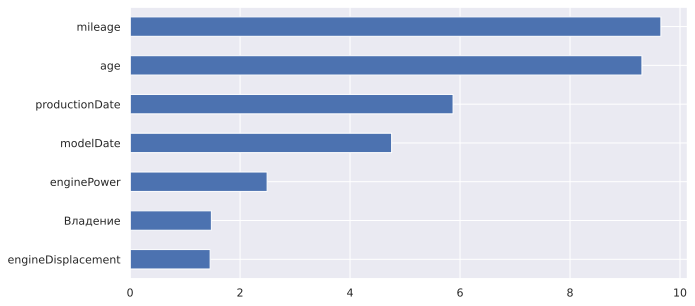

In [73]:
plt.rcParams['figure.figsize'] = (10,5)
#Числовые признаки
imp_num = pd.Series(f_classif(data_preproc.query('sample==1')[num_cols], data_preproc.query('sample==1')['price'])[0], index=num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Влияние числовых признаков - очевидное. Наибольшую роль играют пробег и возраст автомобиля. Оставим все признаки в деле.

 Для категориальных и бинарных признаков используем mutual_info_classif

In [74]:
# отберем категориальные признаки
cat_cols_new = []
for el in data_preproc.drop(['price', 'sample'], axis=1).columns:
    if el not in num_cols:
        cat_cols_new.append(el)
len(cat_cols_new)

170

Text(0.5, 0, 'F-value')

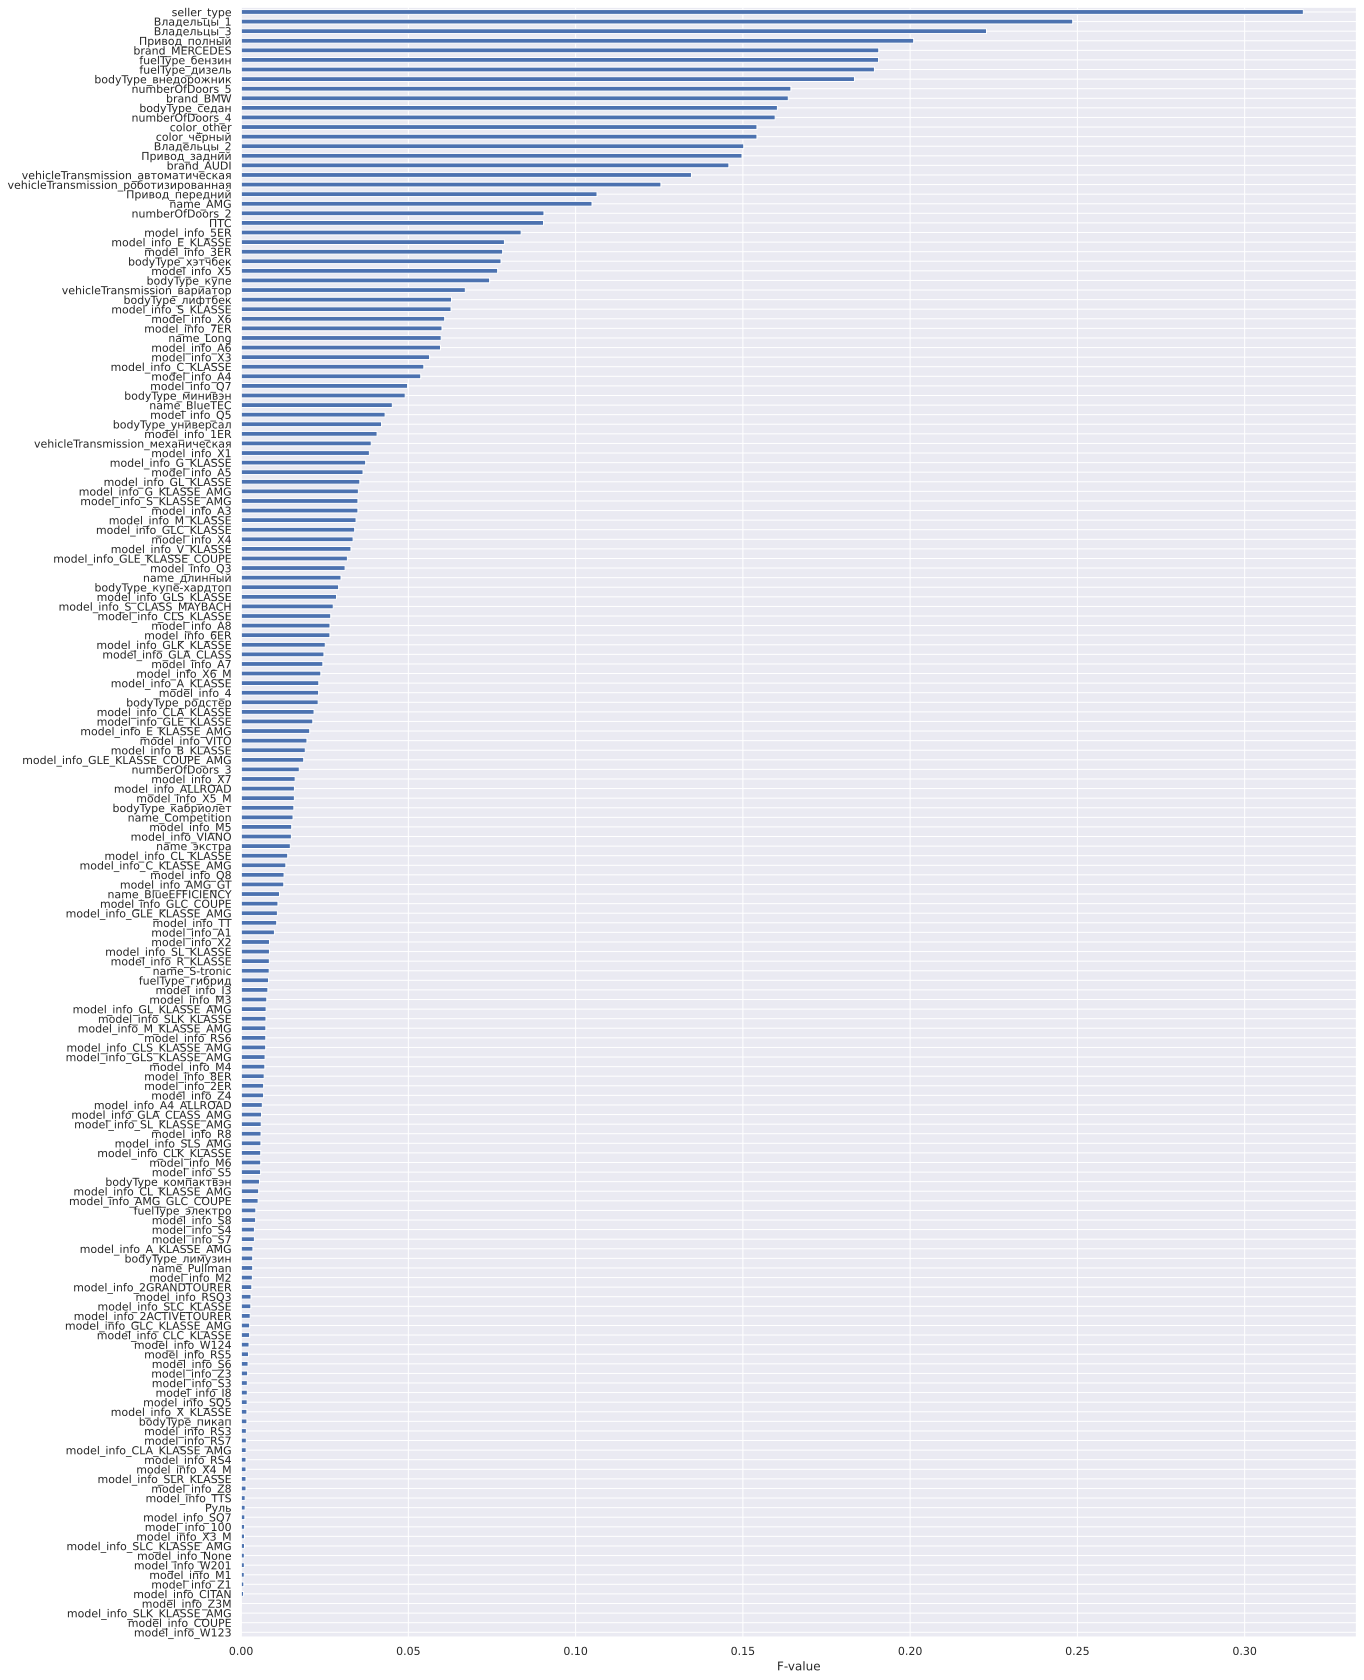

In [75]:
plt.rcParams['figure.figsize'] = (20,30)
imp_cat = pd.Series(mutual_info_classif(data_preproc.query('sample==1')[cat_cols_new], data_preproc.query('sample==1')['price'],
                                     discrete_features=True), index=cat_cols_new)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind = 'barh')
plt.xlabel('F-value')

Dummy переменные, основанные на модели автомобиля имеют наименьшую полезность для модели, но если их не генерировать и не использовать, метрика падает на 1,5%

## Split data

In [76]:
# Теперь выделим тестовую часть
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [77]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 178 entries, engineDisplacement to numberOfDoors_5
dtypes: float64(8), int64(12), uint8(158)
memory usage: 532.0 KB


# Model 2: CatBoostRegressor

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [79]:
cb_model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
cb_model.fit(X_train,  np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418529	test: 0.0419087	best: 0.0419087 (0)	total: 56.1ms	remaining: 4m 40s
100:	learn: 0.0129095	test: 0.0124619	best: 0.0124619 (100)	total: 425ms	remaining: 20.6s
200:	learn: 0.0103478	test: 0.0100091	best: 0.0100091 (200)	total: 1.1s	remaining: 26.3s
300:	learn: 0.0097509	test: 0.0095042	best: 0.0095042 (300)	total: 1.57s	remaining: 24.5s
400:	learn: 0.0093380	test: 0.0091762	best: 0.0091762 (400)	total: 1.82s	remaining: 20.9s
500:	learn: 0.0089972	test: 0.0089536	best: 0.0089536 (500)	total: 2.08s	remaining: 18.7s
600:	learn: 0.0086591	test: 0.0087237	best: 0.0087237 (600)	total: 2.34s	remaining: 17.2s
700:	learn: 0.0083721	test: 0.0085141	best: 0.0085141 (700)	total: 2.61s	remaining: 16s
800:	learn: 0.0081130	test: 0.0083428	best: 0.0083428 (800)	total: 2.87s	remaining: 15s
900:	learn: 0.0079129	test: 0.0082238	best: 0.0082238 (900)	total: 3.14s	remaining: 14.3s
1000:	learn: 0.0077536	test: 0.0081417	best: 0.0081417 (1000)	total: 3.4s	rem

In [80]:
test_predict_catboost = np.exp(cb_model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 10.85%


##### Текущий результат Catboost- 10.85%, улучшение относительно 13.23% в Baseline

Попробуем отобрать 99 самых важных признаков согласно CatBoost. 
- При построении моделей использовался сокращенный набор из 99 самых важных признаков, согласно отбору ниже.
- Для финальных сабмишенов для повышения метрики использовался полный набор признаков, поэтому ячейки ниже закоментированны

In [81]:
cb_features_df = pd.DataFrame({'feature_importance': cb_model.feature_importances_, 
                  'feature_names': X_test.columns}).sort_values(by=['feature_importance'], ascending=False)

In [82]:
cb_features_df[:99]

feature_importance                         feature_names
1             16.093246                           enginePower
2             13.303326                               mileage
0             13.195608                    engineDisplacement
8             12.805949                                   age
4             12.769588                        productionDate
3             12.744206                             modelDate
49             2.167523                       fuelType_дизель
47             1.720474                       fuelType_бензин
104            1.645829                   model_info_G_KLASSE
5              1.170516                              Владение
37             1.031758                        brand_MERCEDES
40             0.840981                         Привод_полный
26             0.778281                      bodyType_минивэн
175            0.581914                       numberOfDoors_4
41             0.569243    vehicleTransmission_автоматическая
34             0.440197                           Владельцы_3
146            0.430503                   model_info_S_KLASSE
31             0.420537                      bodyType_хэтчбек
173            0.391036                       numberOfDoors_2
29             0.345461                        bodyType_седан
105            0.312169               model_info_G_KLASSE_AMG
38             0.273399                         Привод_задний
145            0.260437            model_info_S_CLASS_MAYBACH
152            0.245925                   model_info_V_KLASSE
60             0.239026                        model_info_7ER
39             0.236914                       Привод_передний
45             0.216100                           color_other
44             0.210735  vehicleTransmission_роботизированная
18             0.208271                          name_длинный
156            0.203708                         model_info_X1
88             0.202149                   model_info_E_KLASSE
32             0.195239                           Владельцы_1
36             0.184211                             brand_BMW
67             0.176225                         model_info_A6
20             0.164578                    bodyType_кабриолет
58             0.160446                        model_info_5ER
19             0.155578                  bodyType_внедорожник
56             0.153921                        model_info_3ER
9              0.123352                           seller_type
6              0.120315                                   ПТС
28             0.117605                      bodyType_родстер
158            0.116459                         model_info_X3
164            0.093675                         model_info_X6
17             0.089282                           name_экстра
33             0.088563                           Владельцы_2
43             0.084855      vehicleTransmission_механическая
114            0.081274                   model_info_M_KLASSE
140            0.079198                    model_info_SLS_AMG
22             0.078410                         bodyType_купе
12             0.068662                             name_Long
70             0.057249                    model_info_ALLROAD
86             0.056075                   model_info_C_KLASSE
23             0.054133                 bodyType_купе-хардтоп
162            0.052126                         model_info_X5
35             0.050271                            brand_AUDI
25             0.045127                      bodyType_лифтбек
52             0.043250                        model_info_1ER
59             0.041950                        model_info_6ER
46             0.041777                          color_чёрный
150            0.041648                      model_info_VIANO
30             0.036446                    bodyType_универсал
87             0.036273               model_info_C_KLASSE_AMG
160            0.035052                         model_info_X4
128            0.033462              

In [83]:
'''
cb_features = cb_features_df.feature_names[:99].tolist()
data_preproc_new = data_preproc[cb_features+['price', 'sample']]
data_preproc_new.info()
'''

"\ncb_features = cb_features_df.feature_names[:99].tolist()\ndata_preproc_new = data_preproc[cb_features+['price', 'sample']]\ndata_preproc_new.info()\n"

In [84]:
'''
train_data = data_preproc_new.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc_new.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)
'''

"\ntrain_data = data_preproc_new.query('sample == 1').drop(['sample'], axis=1)\ntest_data = data_preproc_new.query('sample == 0').drop(['sample'], axis=1)\n\ny = train_data.price.values     # наш таргет\nX = train_data.drop(['price'], axis=1)\nX_sub = test_data.drop(['price'], axis=1)\n"

In [85]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)\n'

In [86]:
'''
cb_model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
cb_model.fit(X_train,  np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )
'''

"\ncb_model = CatBoostRegressor(iterations = 5000,\n                          #depth=10,\n                          #learning_rate = 0.5,\n                          random_seed = RANDOM_SEED,\n                          eval_metric='MAPE',\n                          custom_metric=['RMSE', 'MAE'],\n                          od_wait=500,\n                          #task_type='GPU',\n                         )\ncb_model.fit(X_train,  np.log(y_train),\n         eval_set=(X_test, np.log(y_test)),\n         verbose_eval=100,\n         use_best_model=True,\n         #plot=True\n         )\n"

In [87]:
'''
test_predict_catboost = np.exp(cb_model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
'''

'\ntest_predict_catboost = np.exp(cb_model.predict(X_test))\nprint(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")\n'

Получили небольшое ухудшение метрики до 11.06%, но при этом прилично сократили признаковое пространство и выиграли время для вычислений.

### Попытка провести Forward Feature Selection самописной функцией не увенчалась успехом из-за ошибки, которую выдает CatBoost

In [88]:
'''
def evaluate_metric(model, X_test, y_test):
    return mape(y_test, np.exp(model.predict(X_test))*100)
'''    

'\ndef evaluate_metric(model, X_test, y_test):\n    return mape(y_test, np.exp(model.predict(X_test))*100)\n'

In [89]:
'''
def forward_feature_selection(x_train, x_cv, y_train, y_cv, n):
    feature_set = []
    for num_features in range(n):
        metric_list = [] # Choose appropriate metric based on business problem
        model = CatBoostRegressor(verbose=0, allow_const_label=True) # You can choose any model you like, this technique is model agnostic
        for feature in x_train.columns:
            if feature not in feature_set:
                f_set = feature_set.copy()
                f_set.append(feature)
                model.fit(x_train[f_set], np.log(y_train))
                metric_list.append((evaluate_metric(model, x_cv[f_set], y_cv), feature))

        metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"
        feature_set.append(metric_list[0][1])
    return feature_set
'''

'\ndef forward_feature_selection(x_train, x_cv, y_train, y_cv, n):\n    feature_set = []\n    for num_features in range(n):\n        metric_list = [] # Choose appropriate metric based on business problem\n        model = CatBoostRegressor(verbose=0, allow_const_label=True) # You can choose any model you like, this technique is model agnostic\n        for feature in x_train.columns:\n            if feature not in feature_set:\n                f_set = feature_set.copy()\n                f_set.append(feature)\n                model.fit(x_train[f_set], np.log(y_train))\n                metric_list.append((evaluate_metric(model, x_cv[f_set], y_cv), feature))\n\n        metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"\n        feature_set.append(metric_list[0][1])\n    return feature_set\n'

In [90]:
'''
f=forward_feature_selection(X_train, X_test, y_train, y_test, 4)
'''

'\nf=forward_feature_selection(X_train, X_test, y_train, y_test, 4)\n'

### Попробуем реализовать Backward future selection встроенным методам библиотеки mlextend.
Неудачно. 45 минут на одну feature - превысит время допустимой сессии Kaggle.
Оставим текущий набор признаков.

In [91]:
'''
cb = CatBoostRegressor(verbose=0)
fs1 = sfs(cb, k_features=50, forward=False, verbose=2, scoring='neg_mean_squared_error', n_jobs=-1)
'''

"\ncb = CatBoostRegressor(verbose=0)\nfs1 = sfs(cb, k_features=50, forward=False, verbose=2, scoring='neg_mean_squared_error', n_jobs=-1)\n"

In [92]:
'''
sfs1 = sfs1.fit(X_train, y_train)
'''

'\nsfs1 = sfs1.fit(X_train, y_train)\n'

In [93]:
'''
feat_names = list(sfs1.k_feature_names_)
print(feat_names)
'''

'\nfeat_names = list(sfs1.k_feature_names_)\nprint(feat_names)\n'

In [94]:
#sklearn method
#cb = CatBoostRegressor(verbose=0)
#sfs = SequentialFeatureSelector(cb, n_features_to_select=4, direction='forward', n_jobs=-1)
#sfs.fit(X_train, y_train)

### Посмотрим, какие еще модели можно использовать на этих данных

In [95]:
# Закомментировал, потому что установка Lazy Predict сильно обновляет все модули, и перестает работать часть импортов
#lazyr = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = lazyr.fit(X_train, X_test, y_train, y_test)
#print(models)

Первые три модели, предложенные LazyRegressor:

ExtraTreesRegressor   
GradientBoostingRegressor  
LGBMRegressor                   

Градиентный бустинг в числе первых, поэтому использование CatBoost вполне оправдано.

### Попробуем сделать fine-tuning модели CatBoost

In [96]:
'''
model = CatBoostRegressor(iterations = 1000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'depth': [4, 6, 8, 12],
        'l2_leaf_reg': [3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=np.log(y_train),
                                       plot=True,
                                       verbose=1
                                      )

print('\nНаилучшие параметры: ', grid_search_result['params'])
'''

"\nmodel = CatBoostRegressor(iterations = 1000,\n                          random_seed = RANDOM_SEED,\n                          eval_metric='MAPE',\n                          custom_metric=['R2', 'MAE']\n                         )\n\ngrid = {'learning_rate': [0.01, 0.05, 0.1, 0.15],\n        'depth': [4, 6, 8, 12],\n        'l2_leaf_reg': [3, 5, 7, 9]}\n\ngrid_search_result = model.grid_search(grid,\n                                       X=X_train,\n                                       y=np.log(y_train),\n                                       plot=True,\n                                       verbose=1\n                                      )\n\nprint('\nНаилучшие параметры: ', grid_search_result['params'])\n"

Наилучшие параметры:  {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.15}

In [97]:
'''
cb_tuned = CatBoostRegressor(iterations=10000,
                             depth=4,
                             learning_rate = 0.15,
                             l2_leaf_reg = 3,
                             random_seed = RANDOM_SEED,
                             eval_metric='MAPE',
                             custom_metric=['RMSE', 'MAE'],
                             od_wait=500,
                             #task_type='GPU',
                            )
cb_tuned.fit(X_train,  np.log(y_train),
             eval_set=(X_test, np.log(y_test)),
             verbose_eval=100,
             use_best_model=True,
             #plot=True
            )
'''            

"\ncb_tuned = CatBoostRegressor(iterations=10000,\n                             depth=4,\n                             learning_rate = 0.15,\n                             l2_leaf_reg = 3,\n                             random_seed = RANDOM_SEED,\n                             eval_metric='MAPE',\n                             custom_metric=['RMSE', 'MAE'],\n                             od_wait=500,\n                             #task_type='GPU',\n                            )\ncb_tuned.fit(X_train,  np.log(y_train),\n             eval_set=(X_test, np.log(y_test)),\n             verbose_eval=100,\n             use_best_model=True,\n             #plot=True\n            )\n"

In [98]:
'''
test_predict_catboost = np.exp(cb_tuned.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
'''

'\ntest_predict_catboost = np.exp(cb_tuned.predict(X_test))\nprint(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")\n'

Модель с параметрами из grid_search показала метрику 11.49%, что хуже, поэтому оставим первоначальные, по сути дефолтные настройки.

### Submission

In [99]:
sub_predict_catboost = np.exp(cb_model.predict(X_sub)) // 1000 * 1000 # округляем до 1000
sample_submission['price'] = sub_predict_catboost 
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [100]:
''' Baseline
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))
'''

' Baseline\nmodel = Sequential()\nmodel.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))\nmodel.add(L.Dropout(0.5))\nmodel.add(L.Dense(256, activation="relu"))\nmodel.add(L.Dropout(0.5))\nmodel.add(L.Dense(1, activation="linear"))\n'

In [101]:
''' Baseline
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
'''

" Baseline\n# Compile model\noptimizer = tf.keras.optimizers.Adam(0.01)\nmodel.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])\n"

In [102]:
''' Baseline
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]
'''

" Baseline\ncheckpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')\nearlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)\ncallbacks_list = [checkpoint, earlystop]\n"

### Fit

In [103]:
''' Baseline
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )
'''

' Baseline\nhistory = model.fit(X_train, y_train,\n                    batch_size=512,\n                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение\n                    validation_data=(X_test, y_test),\n                    callbacks=callbacks_list,\n                    verbose=0,\n                   )\n'

In [ ]:
''' Baseline
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
'''

Получена метрика 11.45%, что лучше чем 14.01% в Baseline. Это достигнуто засчет выполненных рекомендаций по обработке и генерации признаков, логарифмирования числовых признаков, для улучшения их распределения, сокращения размерности категориальных признаков (цвет, кузов).

Попробуем модицифицировать нейронную сеть добавлением еще одного слоя и батч-нормализацией

In [105]:
model_mlp = Sequential()

model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5, seed=RANDOM_SEED))

model_mlp.add(L.Dense(256, activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.25, seed=RANDOM_SEED))

model_mlp.add(L.Dense(128, activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.25, seed=RANDOM_SEED))

model_mlp.add(L.Dense(1, activation='linear'))
#Информация о собранной модели
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               91136     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

### Добавим управление learning rate 

In [106]:
# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.08,
    decay_steps=10000,
    decay_rate=0.96
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [107]:
#checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
#callbacks_list = [checkpoint, earlystop]
callbacks_list = [earlystop] # Оставим только earlystopping поскольку именно он сохраняет лучшие веса модели.

In [108]:
history = model_mlp.fit(X_train, y_train,
                        batch_size=512,
                        epochs=2000, # обучаемся пока EarlyStopping не остановит обучение
                        validation_data=(X_test, y_test),
                        callbacks=callbacks_list,
                        verbose=1
                       )

Epoch 1/2000
12/12 [==============================] - 2s 58ms/step - loss: 99.9973 - MAPE: 99.9973 - val_loss: 99.9663 - val_MAPE: 99.9663
Epoch 2/2000
12/12 [==============================] - 0s 8ms/step - loss: 99.9679 - MAPE: 99.9679 - val_loss: 99.9835 - val_MAPE: 99.9835
Epoch 3/2000
12/12 [==============================] - 0s 8ms/step - loss: 99.8885 - MAPE: 99.8885 - val_loss: 99.6983 - val_MAPE: 99.6983
Epoch 4/2000
12/12 [==============================] - 0s 8ms/step - loss: 99.7443 - MAPE: 99.7443 - val_loss: 99.1048 - val_MAPE: 99.1048
Epoch 5/2000
12/12 [==============================] - 0s 8ms/step - loss: 99.5258 - MAPE: 99.5258 - val_loss: 98.6225 - val_MAPE: 98.6225
Epoch 6/2000
12/12 [==============================] - 0s 8ms/step - loss: 99.2055 - MAPE: 99.2055 - val_loss: 98.2671 - val_MAPE: 98.2671
Epoch 7/2000
12/12 [==============================] - 0s 8ms/step - loss: 98.7955 - MAPE: 98.7955 - val_loss: 97.2082 - val_MAPE: 97.2082
Epoch 8/2000
12/12 [=============

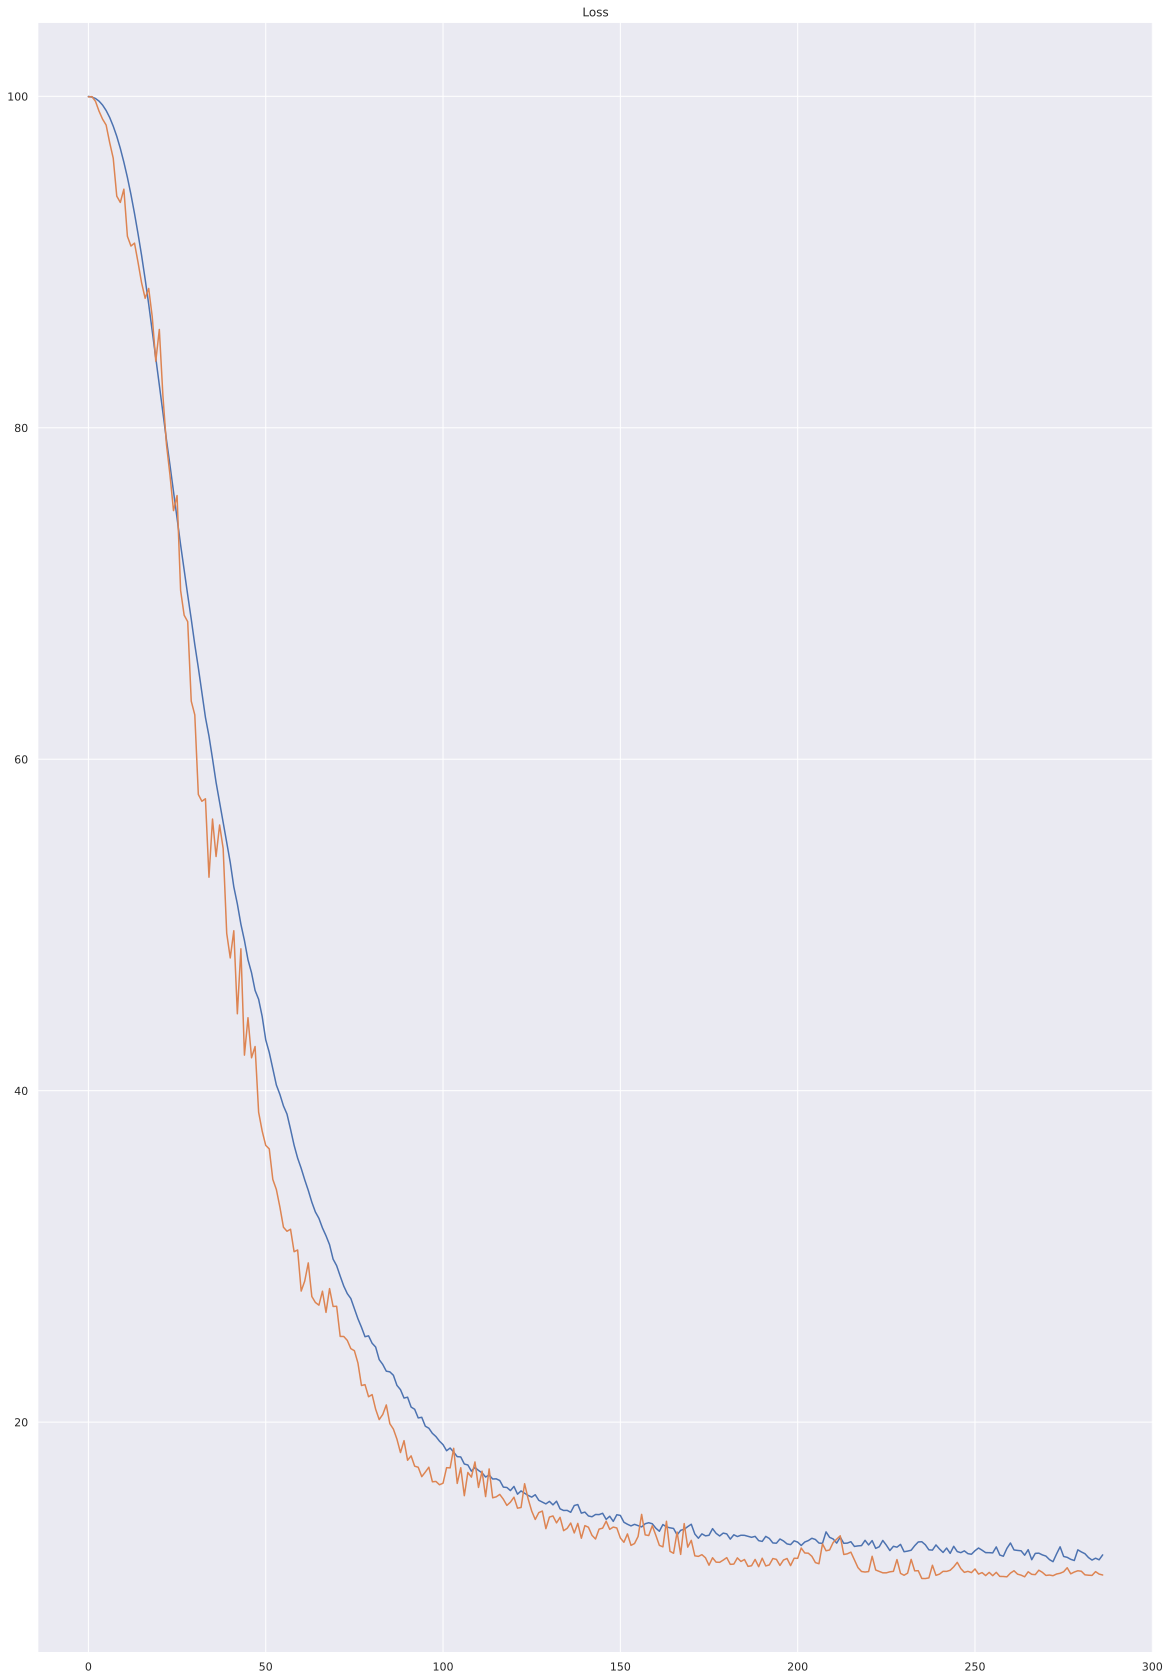

In [109]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [110]:
#model_mlp.load_weights('../working/best_model.hdf5') 
model_mlp.save('../working/model_mlp.hdf5')

In [111]:
test_predict_mlp = model_mlp.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_mlp[:,0]))*100:0.2f}%")

TEST mape: 10.56%


Получилось улучшиться с 11.45% до 10.76%. Показатель на уровне ML-модели CatBoost

In [112]:
sub_predict_nn1 = model_mlp.predict(X_sub) // 1000 * 1000 # округляем до 1000
sample_submission['price'] = sub_predict_nn1[:,0] 
sample_submission.to_csv('mlp_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [113]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 271 kB/s 
     |████████████████████████████████| 8.2 MB 5.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c793df120f60627fd3db895947a168ddc18d203578d151d97e9df9599f4137b5
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [114]:
import pymorphy2
from nltk.corpus import stopwords

### Для работы с текстом, обработаем столбец с описанием автомобилей

In [115]:
### Функция лемматизирующая запись и удаляющая стоп-слова
ru_stopwords = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()
def preprocess(record):
    new_record = ''
    for word in record.split(' '):
        if word!= '' and word[0].isdigit()==False and word not in ru_stopwords:
            new_word = morph.normal_forms(word)[0]
            if len(new_word) > 2:
                new_record += (new_word + ' ')
     
        
    return (new_record)        

### Кроме лемматизации, отбросим слова, не имеющие отношения к автомобилю и являющиеся рекламой дилера

In [116]:
 drop_keywords = [
     'кредитование','клиент', 'кредитный', 'процентный', 'ставка', 'avilon', 'наша компания', 'специальный', 'предложение',
     'выкуп', 'выгода', 'лизинг', 'рольф', 'официальный', 'дилерский', 'дилер', 'срочный' ,'выкуп', 'дарить', 'набор', 'подарок', 'покупка',
     'правильный' 'выбор', 'атлант-м', 'тушино', 'скидка', 'рассрочка', 'автоцентр', 'преимущество', 'автокредитование', 'кредит',
     'автомир', 'автомобиль', 'код', 'асц', 'комиссионный', 'каско', 'обязательно', 'major', 'expert', 'ежедневно', 'выходной', 'обмен',
     'лот','тест-драйв', 'сертифицированный', 'das', 'weltauto', 'бизнес', 'кар', 'банк', 'партнёр', 'партнер', 'trade-in', 'trade',
     'трейд-ин', 'трейд', 'каждый', 'проходить', 'предпродажный', 'подготовка', 'ясенево', 'favorit','ждать', 'взнос', 'автогермес',
     'автопрага', 'сотрудник', 'минимальный', 'ежемесячный', 'платёж', 'срок', 'купить', 'продать', 'панавто', 'авто', 'позвонить',
     'узнать', 'полис', 'программа', 'предлагать', 'обременение', 'юридический', 'наличие', 'обеспечивать', 'полный', 'прозрачность',
     'финансовый', 'ооо', 'abtodom'
    ]

In [117]:
### Функция обработки текстовой записи столбца description
def descr_clean (record):
    record = re.sub('\n', ' ', record)
    record = re.sub('\t', ' ', record)
    record = re.sub(r'\W', ' ', record)
    record = re.sub(r'[.!@"“’«»#$%&\'()*+,—/:;<=>?^_`{|}~\[\]]', '', record)
    record = preprocess(record)
    for word in drop_keywords:
        record = re.sub(word, ' ', record.lower())
    return record

### Пример, как выглядит запись до и после обработки

In [118]:
data.description[17]

'В продаже автомобили от компании АО ABTODOM, официальный дилер (BMW, MINI, BMW i, BMW Motorrad, Mercedes-Benz, Smart, Lamborghini).\nВсе автомобили, для Вашего удобства, находятся на теплом паркинге!\nБолее 200 автомобилей с пробегом под одной крышей!\n\nМы готовы Вам предложить Автомобили с пробегом от Официального Дилера ABTODOM ВНУКОВО! На нашем складе более 200 автомобилей. \nСрочный выкуп день-в-день!\n\nABTODOM ВНУКОВО – официальный дилерский центр BMW, MINI входящий в состав ГК  ABTODOM – являющегося одним из крупнейших игроков российского авторитейла. В состав ГК ABTODOM  входят такие бренды как: BMW, MINI, BMW i, BMW Motorrad, Mercedes-Benz, Smart, AUDI, VOLVO, Jaguar, Land Rover, Ducati, Lamborghini и 15 дилерских центров в Москве и Санкт Петербурге.\n\nВсе автомобили прошли полную техническую диагностику у официального дилера.\nТехническая диагностика – это комплексная проверка состояния всех наших автомобилей. Со всеми результатами диагностики Вы можете подробно ознакомить

In [119]:
print(descr_clean(data.description[17]))

продажа   компания       bmw mini bmw bmw motorrad mercedes benz smart lamborghini всё   ваш удобство находиться тепло паркинг более   пробег один крыша готовый предложить   пробег       внуково наш склад       день день   внуково     центр bmw mini входящий состав   являться один крупный игрок российский  ритейл состав   входить такой бренд bmw mini bmw bmw motorrad mercedes benz smart audi volvo jaguar land rover ducati lamborghini   центр москва санкт петербург всё   пройти   технический диагностик     технический диагностика это комплексный проверка состояние наш   весь результат диагностика мочь подробно ознакомиться салон кузов лакокрасочный покрытие проверить специализировать оборудование   пройти     проверка     осмотр   перерыв   всё наш   площадка   внуково мочь посмотреть нажать ссылка продавец   контактный информация 


In [120]:
# Обработка признака занимала приличное время, что неудобно при отладке и подборе параметров нейросетей,
# поэтому будем загружать готовый обработанный признаком отдельным датасетом.
#%%time
#data.description = data.description.apply(lambda x: descr_clean(x))

In [121]:
data_description_cleaned.description.fillna(' ', inplace=True)

In [122]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [123]:
# split данных
text_train = data_description_cleaned.description.iloc[X_train.index]
text_test = data_description_cleaned.description.iloc[X_test.index]
text_sub = data_description_cleaned.description.iloc[X_sub.index]

### Tokenizer

In [124]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_description_cleaned.description)

CPU times: user 1.02 s, sys: 5.34 ms, total: 1.02 s
Wall time: 1.14 s


In [125]:
len(tokenize.word_index)

18906

Первоначальный словарь содержал 39591 токен. После лемматизации и удаления стоп-слов и пунктуации - 19135 токенов. После удаление характерных для автосалонов слов - 18906

In [126]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 873 ms, sys: 4.98 ms, total: 878 ms
Wall time: 877 ms


In [127]:
# вот так теперь выглядит наш векторизованный текст
print(text_train.iloc[6])
print(text_train_sequences[6])

  проверить пункт        ауди центр север     audi входящий группа компания   являться один крупный   европа   ряд услуга   продажа   пробег протяжение многий год наш   центр являться лидер продажа   пробег среди   audi россия предоставлять   самый большой выбор   пробег audi другой марка       тщательный диагностик   гарантировать находиться отличный состояние чтобы убедиться правильный выбор возможность пройти тест драйв ознакомительный поездка интересовать   смочь ознакомиться   выходить дом наш менеджер провести online презентация видеозвонок показать выбрать   также ауди центр север представлять уникальный       пробег индивидуальный условие специалист компания подобрать хороший условие   более проверить   пробег гарантия год   сайт rolf probeg мобильный приложение мой   
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

### RNN NLP

In [128]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(32, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [129]:
model_mlp1 = Sequential()

model_mlp1.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_mlp1.add(L.BatchNormalization())
model_mlp1.add(L.Dropout(0.5, seed=RANDOM_SEED))

model_mlp1.add(L.Dense(256, activation='relu'))
model_mlp1.add(L.BatchNormalization())
model_mlp1.add(L.Dropout(0.25, seed=RANDOM_SEED))

model_mlp1.add(L.Dense(128, activation='relu'))
model_mlp1.add(L.BatchNormalization())
model_mlp1.add(L.Dropout(0.25, seed=RANDOM_SEED))

### Multiple Inputs NN

In [130]:
combinedInput = L.concatenate([model_nlp.output, model_mlp1.output])
# being our regression head
head = L.Dense(128, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp1.input], outputs=head)

In [131]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_6_input (InputLayer)      [(None, 177)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4840192     seq_description[0][0]            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          91136       dense_6_input[0][0]              
______________________________________________________________________________________________

### Fit

Попробуем другой scheduler для управления learning rate

In [132]:
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [133]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [134]:
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [earlystop]

In [135]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 9s 316ms/step - loss: 95.0217 - MAPE: 95.0217 - val_loss: 51.4177 - val_MAPE: 51.4177
Epoch 2/500
12/12 [==============================] - 3s 269ms/step - loss: 53.9825 - MAPE: 53.9825 - val_loss: 83.6520 - val_MAPE: 83.6520
Epoch 3/500
12/12 [==============================] - 3s 243ms/step - loss: 48.9139 - MAPE: 48.9139 - val_loss: 81.2509 - val_MAPE: 81.2509
Epoch 4/500
12/12 [==============================] - 3s 245ms/step - loss: 42.5690 - MAPE: 42.5690 - val_loss: 66.1728 - val_MAPE: 66.1728
Epoch 5/500
12/12 [==============================] - 3s 251ms/step - loss: 33.2148 - MAPE: 33.2148 - val_loss: 75.6933 - val_MAPE: 75.6933
Epoch 6/500
12/12 [==============================] - 3s 248ms/step - loss: 27.9202 - MAPE: 27.9202 - val_loss: 83.4248 - val_MAPE: 83.4248
Epoch 7/500
12/12 [==============================] - 3s 243ms/step - loss: 35.3466 - MAPE: 35.3466 - val_loss: 76.2469 - val_MAPE: 76.2469
Epoch 8/500
12/12 [========

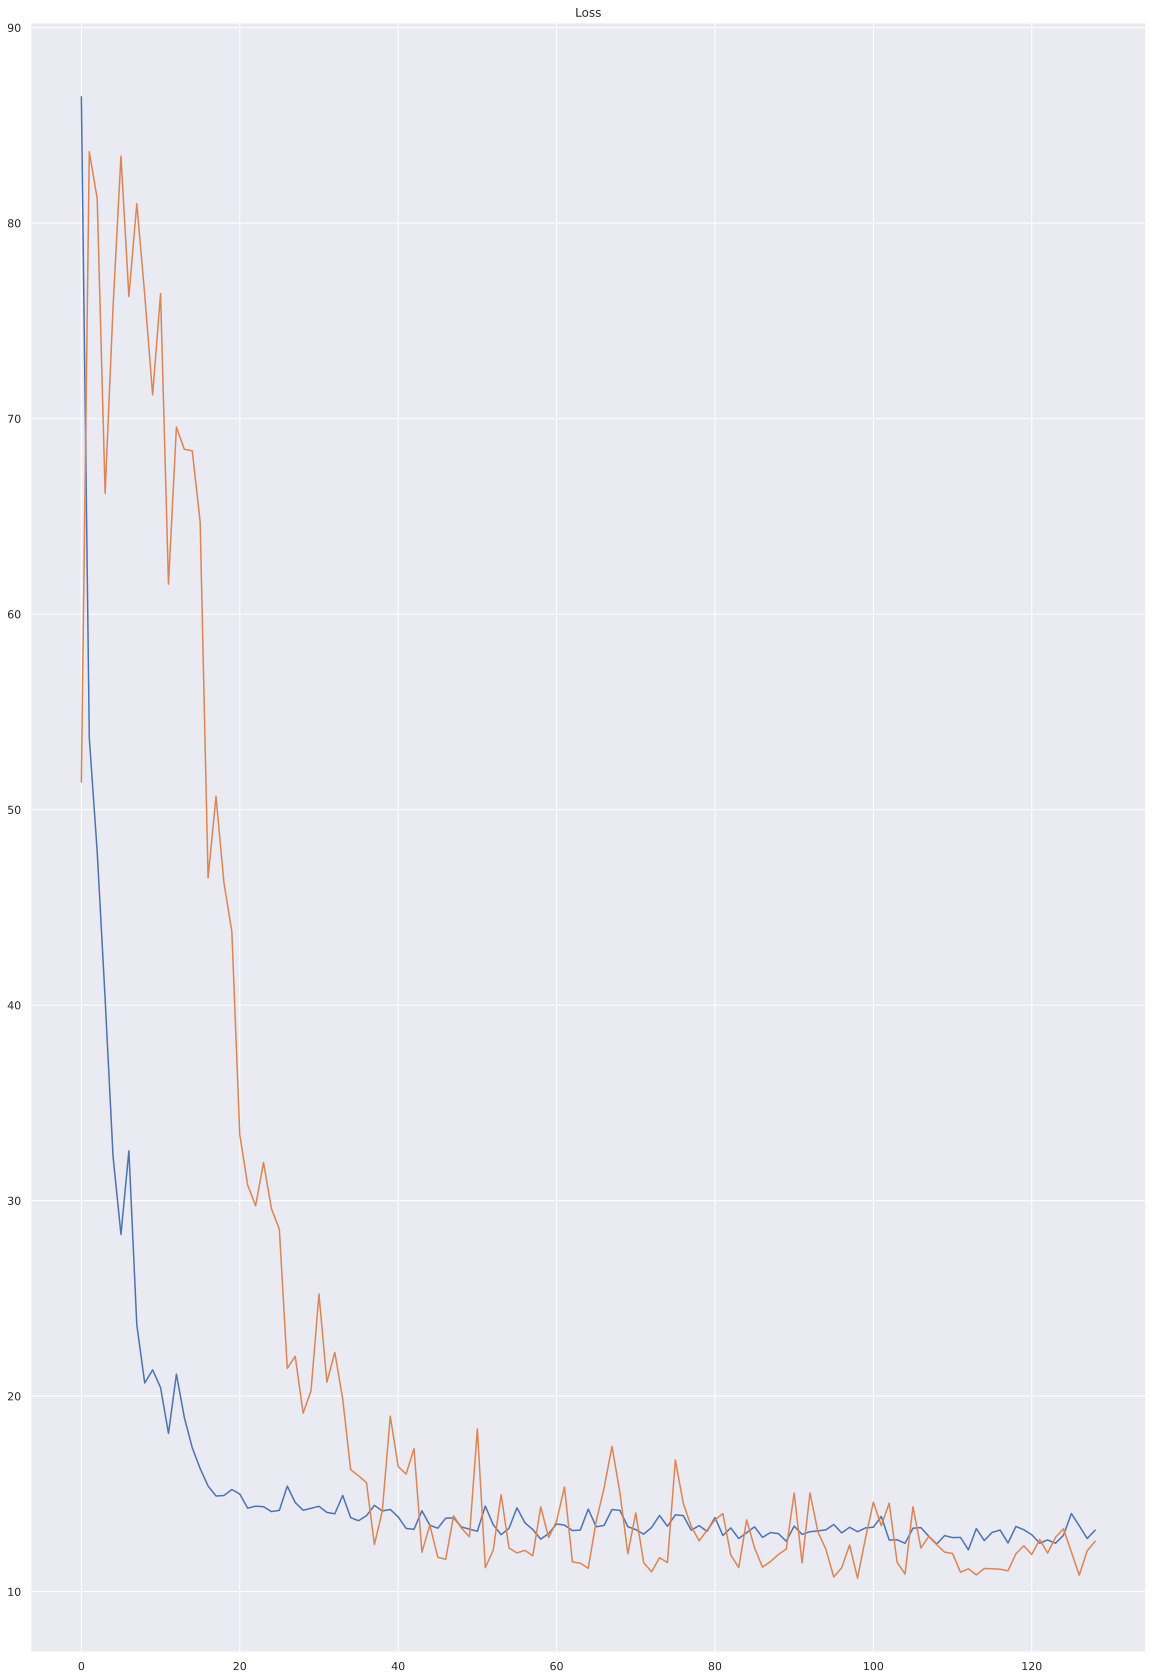

In [136]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [137]:
model.save('../working/nn_mlp_nlp.hdf5')

In [138]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.69%


TEST mape по коду из baseline: 11.66%.
- После обработки description получилось 11.84%.
- После удаления неинформативных слов и добавление lr scheduler - 11.41
- Добавление lstm слоя результата не принесло
- Вообще результаты сложно воспроизводимы. Обладая текущими знаниями я это пока уяснить не могу.
- Лучший полученный результат был - 10.93, с применением архитектуры для работы с табличными данными, полученной на прошлом этапе + когда в nlp сеть был добавлен дополнительный dense слой с 32 нейронами + с увеличением числа нейронов в голове до 128. 

In [139]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub]) // 1000 * 1000 # округляем до 1000
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('mlp+nlp_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

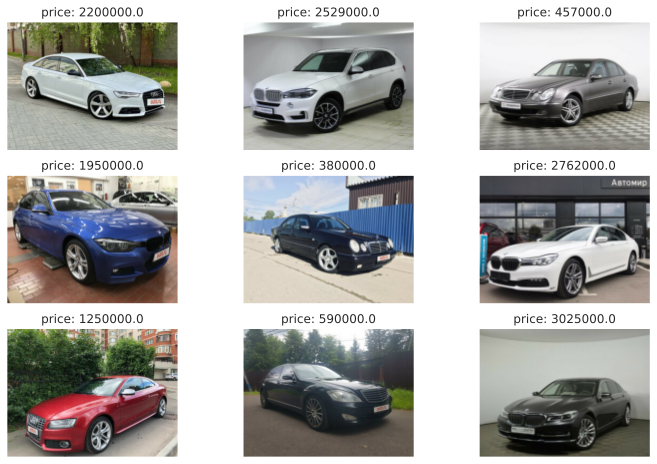

In [140]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [141]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

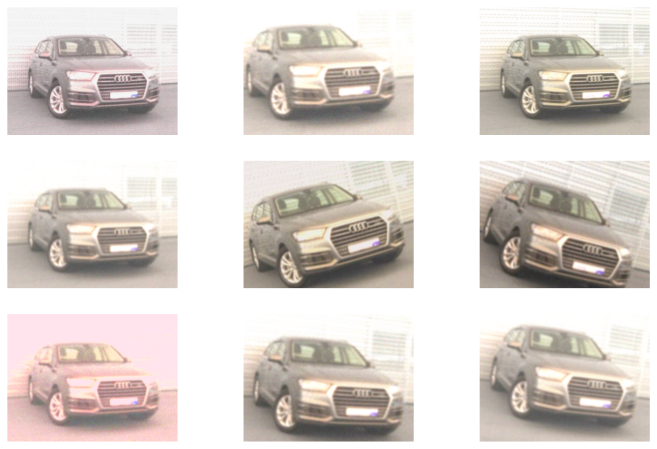

In [142]:
#Будем применять к фотографиям аугментацию на основе реально возможных искажений фотографии

p = 1 #Вероятность аугментации

augmentation = alb.Compose([
    #Размытие изображения
    alb.GaussianBlur(p=p),
    #Добавление шума
    alb.GaussNoise(p=p),
    #Поворот вокруг вертикальной оси
    alb.HorizontalFlip(p=p),
    #Изменение яркости
    alb.RandomBrightness(p=p,limit=(0.1,0.3)),
    #Изменение контраста
    alb.RandomContrast(p=p,limit=(0.1,0.3)),
    #Насыщенность цвета
    alb.HueSaturationValue(p=0.3),
    #Вращение изображения
    alb.ShiftScaleRotate(shift_limit=0.0625,      # сдвиг
                         scale_limit=(0.1,0.2),   # изменение масштаба
                         interpolation=1,         
                         border_mode=4,  
                         rotate_limit=20,         #Лимит угла поворота
                         p=0.7) 
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[14])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [143]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [144]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_description_cleaned.description)

In [145]:
# Набор функций для созданий выборок с применением итератора tf.data.Dataset
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

# Создадим выборки
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data_description_cleaned.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data_description_cleaned.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data_description_cleaned.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [146]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [147]:
# Нейросеть для анализа табличных данных. Не будем увеличивать количество слоев. Батч-нормализация дает ухудшение метрики.
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    #L.BatchNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    #L.BatchNormalization(),
    L.Dropout(0.5), #0.25
])


In [148]:
# NLP - архитектуру оставим как есть
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

In [149]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [150]:
# добавим управление lr
starter_learning_rate = 0.05
end_learning_rate = 0.005
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [151]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [152]:
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [earlystop]

In [153]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 145s 683ms/step - loss: 42.7475 - MAPE: 42.7475 - val_loss: 19.5806 - val_MAPE: 19.5806
Epoch 2/100
190/190 [==============================] - 127s 668ms/step - loss: 18.0827 - MAPE: 18.0827 - val_loss: 21.2678 - val_MAPE: 21.2678
Epoch 3/100
190/190 [==============================] - 127s 664ms/step - loss: 17.9462 - MAPE: 17.9462 - val_loss: 15.2540 - val_MAPE: 15.2540
Epoch 4/100
190/190 [==============================] - 127s 667ms/step - loss: 17.3122 - MAPE: 17.3122 - val_loss: 13.9930 - val_MAPE: 13.9930
Epoch 5/100
190/190 [==============================] - 127s 664ms/step - loss: 16.4093 - MAPE: 16.4093 - val_loss: 13.7488 - val_MAPE: 13.7488
Epoch 6/100
190/190 [==============================] - 127s 666ms/step - loss: 16.0821 - MAPE: 16.0821 - val_loss: 12.5064 - val_MAPE: 12.5064
Epoch 7/100
190/190 [==============================] - 127s 668ms/step - loss: 14.9257 - MAPE: 14.9257 - val_loss: 13.5109 - val_MAPE: 13.5109

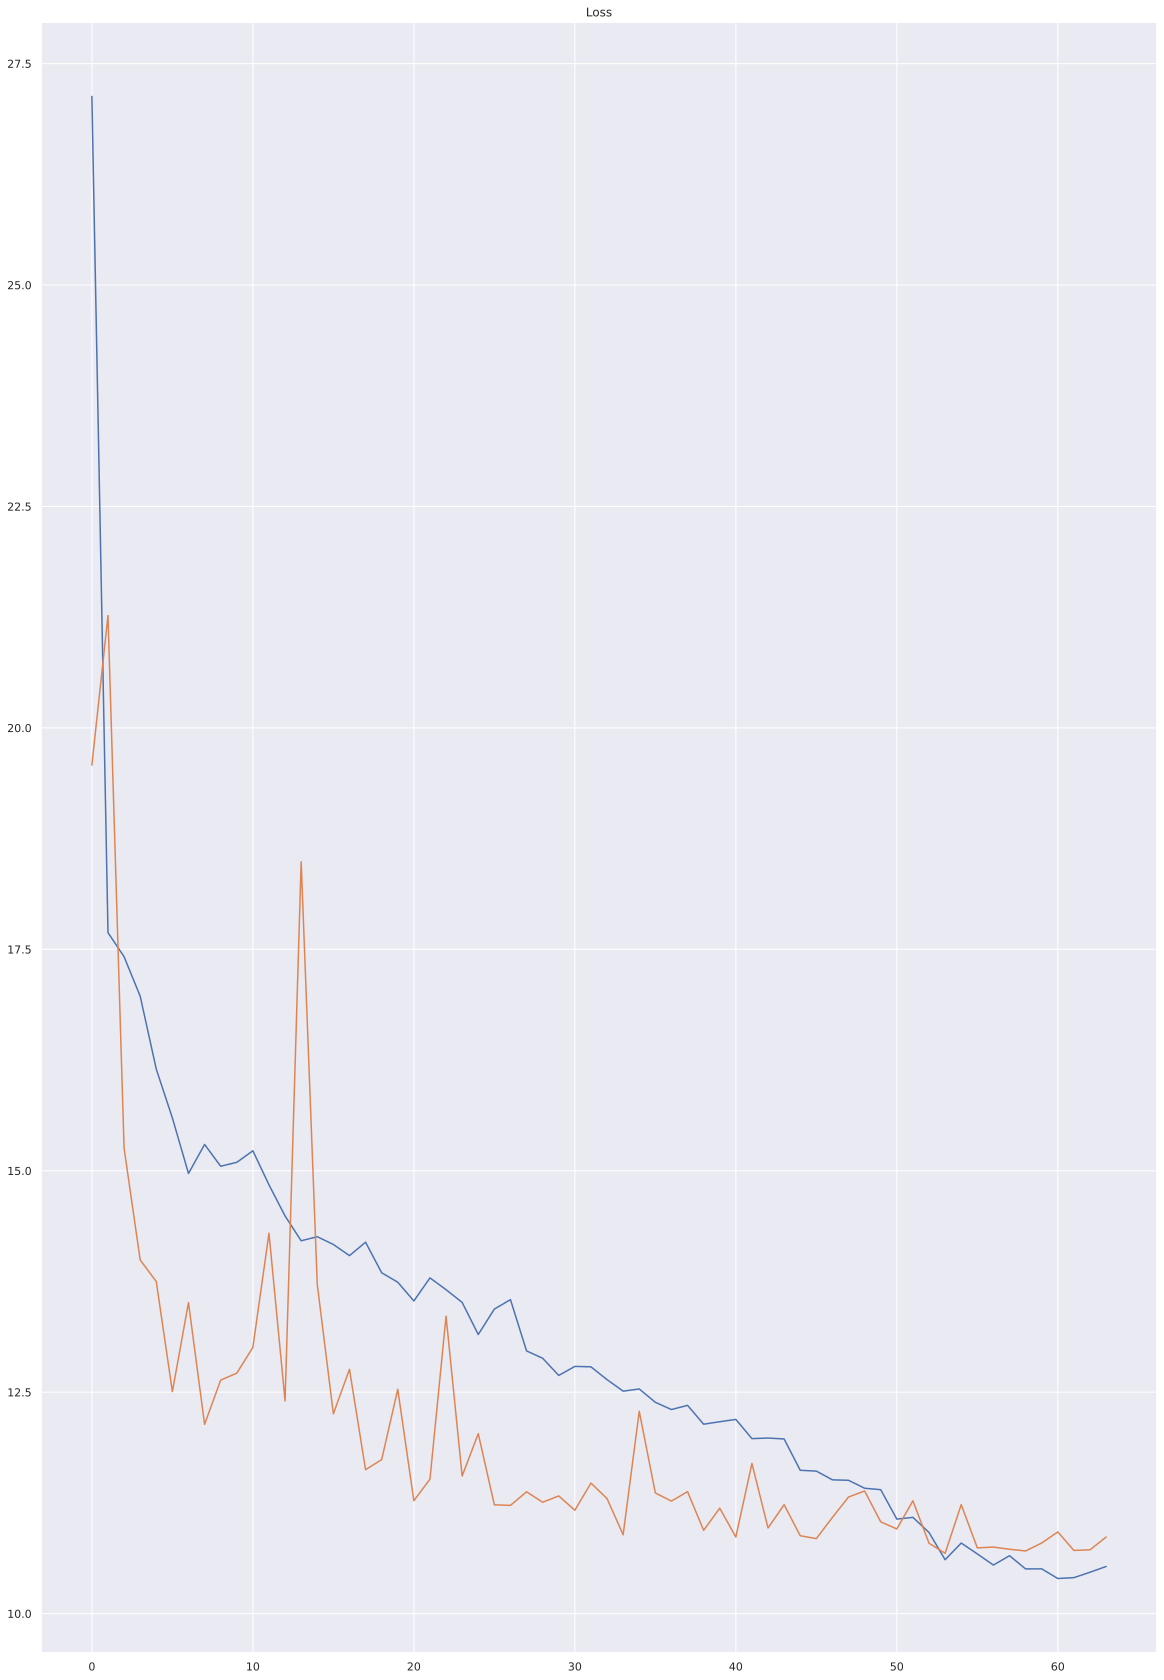

In [154]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

model.save('../working/nn_final.hdf5')

In [155]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 10.68%


Лучший полученный результат - 11.71% Улучшения относительно этапов MLP, MLP+NLP не наблюдается. Вообще обучение такой сети - дело неблагодарное, чтобы оценить изменение архитектуры необходима уйма времени. Пока оставим в таком виде, посмотрим, что даст Blending.

In [156]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30)) // 1000 * 1000 # округляем до 1000
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('mlp+nlp+effnet_submission.csv', index=False)

# Blend

Вариант 1

In [157]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.32%


Blending CatBoost и MultiInput NN дал нам метрику - 10.65%.

In [158]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2 // 1000 * 1000 # округляем до 1000
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Вариант 2

In [159]:
blend_predict2 = (test_predict_catboost + test_predict_mlp[:,0]) / 2 
print(f"TEST mape: {(mape(y_test, blend_predict2))*100:0.2f}%")

TEST mape: 10.24%


Blending CatBoost и Tabular MLP дал нам метрику - 10.22%.

In [160]:
blend_sub_predict2 = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2 // 1000 * 1000 # округляем до 1000
sample_submission['price'] = blend_sub_predict2
sample_submission.to_csv('blend_submission2.csv', index=False)

# Выводы

### Лучшую метрику в лидерборде дало ассамблирование моделей CatBoost и Tabular NN - 11.01376 и 11 место.
- Табличная MLP нейронная сеть дала на валидации метрику сравнимую с CatBoost и даже немного лучше, но в сабмишене не опередила блендинг двух моделей.
- MultiInput сети при тестировании тоже дали неплохой результат, добавление картинок и дообучение EfficientNet дало некоторое улучшение метрики, но незначительно. Особенно хорошая метрика у MultiInput нейросетей  получилась при сабмишене ноутбука, но видно где-то имеет место переобучение, поэтому в сабмишене блендинг опередить не удалось.
- Работа с текстовым полем дала улучшение метрики относительно Baseline модели. Текст был лемматизирован, убраны токены, начинающиеся на цифры, убрана реклама автосалонов.
- При добавлении в оптимизатор нейронных сетей управления learning rate - результаты модели улучшаются.

#### Что можно сделать еще
- Можно было бы организовать в конце вместо усреднения предсказаний - Stacking моделей, но что-то мне подсказывает, что выборка для стекинга довольно небольшая. Но попробовать стоит
- Надо сделать обучение CatBoost с кросс-валидацией и усреднением предсказаний, это помогло улучшить метрику в предыдущем проекте.
- Для осознанного изменения архитектуры сетей надо знать про нейросети намного больше, чем сейчас. 
- Обучение нейросетей - дело долгое и иногда непредсказуемое. Чтобы не тыкаться вслепую - надо больше знаний.

# Model Bonus: проброс признака

In [ ]:
'''
# MLP
#model_mlp1 = Sequential()

#model_mlp1.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model_mlp1.add(L.BatchNormalization())
#model_mlp1.add(L.Dropout(0.5, seed=RANDOM_SEED))

#model_mlp1.add(L.Dense(256, activation='relu'))
#model_mlp1.add(L.BatchNormalization())
#model_mlp1.add(L.Dropout(0.25, seed=RANDOM_SEED))#

#model_mlp1.add(L.Dense(128, activation='relu'))
#model_mlp1.add(L.BatchNormalization())
#model_mlp1.add(L.Dropout(0.25, seed=RANDOM_SEED))

# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))
'''

In [162]:
# Самые значимые признаки в модели CatBoost
# enginePower, mileage, age

### На этом этапе возникли проблемы с индексами эмбеддинга. Пока откладываем.

In [ ]:
'''
# FEATURE Input
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)
'''

In [ ]:
'''
# FEATURE Input
mileage = L.Input(shape=[1], name="mileage")
# Embeddings layers
emb_mileage = L.Embedding(len(X.mileage.unique().tolist())+1, 20)(mileage)
f_mileage = L.Flatten()(emb_mileage)
'''

In [ ]:
'''
combinedInput = L.concatenate([model_mlp1.output, f_mileage,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp1.input, mileage], outputs=head)
'''

In [ ]:
'''
combinedInput = L.concatenate([model_mlp.output, f_productiondate])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)
'''

In [ ]:
'''
model.summary()
'''

In [ ]:
'''
starter_learning_rate = 0.05
end_learning_rate = 0.005
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
'''

In [ ]:
'''
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [earlystop]
'''

In [ ]:
'''
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )
'''

In [ ]:
'''
model.save('../working/nn_bonus.hdf5')
'''

In [ ]:
'''
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")
'''

In [ ]:
'''
sample_submission['price'] = test_predict_nn_bonus[:,0] // 1000 * 1000 # округляем до 1000
sample_submission.to_csv('nn_bonus_submission.csv', index=False)
'''